# Watt‑Saver ⚡ — Home‑Level Personalized Energy Coach

## Stage 1 | The Mystery Bill
Households often feel powerless when their electricity bill shoots up: the statement lists kilowatt‑hours but not the practical “why” or “how to fix it.” **Watt‑Saver** turns a single home’s smart‑meter and appliance logs into clear, actionable guidance that lowers costs without guesswork.

## Stage 2 | Why GenAI for a Single Home?  
Charts and tables describe *what* happened; GenAI explains **why** it happened and **what to do next**. A Gemini‑powered workflow converts raw readings into conversational insights (“the heat‑pump spiked at 6 a.m. during defrost”) and suggests concrete actions (“run the dryer after 22 h to avoid peak rates”).

## Stage 3 | Data in the Trenches
| Source | Granularity | Key Columns | Role in Watt‑Saver |
|---|---|---|---|
| **Smart‑meter feed** | Hourly | start_time, end_time, total kWh, cost | Captures whole‑home load and tariff. |
| **Appliance events** | Per‑use | Appliance Type, kWh, Time, Date, Temp °C, Season, Household Size | Pinpoints which devices drive consumption. |

## Stage 4 | Clean‑Up & Crunch
1. Clean timestamps, coerce numeric fields, drop corrupt rows.  
2. Resample meter data to daily & monthly totals.  
3. Aggregate appliance events to hourly for side‑by‑side comparison.  
4. Calculate baseline (night‑time) load to surface phantom usage.

## Stage 5 | GenAI in Action
* **Prompt templates** for narrative summaries, cost breakdowns, and “what‑if” scenarios.  
* **Few‑shot examples** teach Gemini to return SQL queries, plots, or bullet‑point advice.  
* **Optional LangGraph agent** pulls 3‑day weather forecasts to predict upcoming HVAC costs.

## Stage 6 | Headline Discoveries
* **Top cost drivers** – HVAC and water heating typically exceed 60 % of total kWh.  
* **Tariff verification** – Fixed rate around \$0.166 /kWh confirmed from meter data.  
* **Seasonal peaks** – Cold‑spell spikes identified with insulation and thermostat tweaks proposed.  
* **Quick wins** – Stand‑by electronics often account for 5–10 % of the bill; smart‑plug schedules recommended.

## Stage 7 | Road Ahead - The Personalized Energy Coach
**Watt‑Saver** equips any household with an easy‑to‑follow action plan. Future enhancements include automated device control through a smart‑home hub, live weather‑driven forecasts, and an optional link to the neighbourhood‑level **Watt‑Saver** dashboard for peer benchmarking.

> *From raw watts to real savings—empowering every household, every day.*

## 🚀 Quick‑Start Notebook — Watt‑Saver Data Sandbox

This lightweight Kaggle notebook jump‑starts **home‑energy analysis** by:

* 📥 **Loading** smart‑meter and appliance‑event datasets  
* 🔍 **Running** basic exploratory queries & visual checks
* 🛠️ **Preparing** the data for deeper GenAI‑driven insights


### 🕑 Hourly Smart‑Meter Schema

| Column | Description |
|---|---|
| **start_time** | Timestamp marking the beginning of the hour |
| **end_time** | Timestamp marking the end of the hour |
| **consumption** | Energy used during the hour (kWh) |
| **provided_cost** | Cost charged for that hour (local currency) |
| **start_minus_prev_end** | Seconds between this record’s start and the previous record’s end (gap check) |
| **end_minus_prev_end** | Seconds between this record’s end and the previous record’s end (overlap / drift check) |


### Setup

Install the Gemini Python SDK, then import it.
Also import helpers to render the output

In [ ]:
!pip uninstall -qqy jupyterlab kfp 2>/dev/null  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"
!pip install -Uq "google-genai==1.7.0"
from IPython.display import display, Image, Markdown, Audio
from google import genai
from google.genai import types
genai.__version__
warnings.filterwarnings("ignore", category=UserWarning)


### Import Dataset


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
document_files = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        document_files.append(os.path.join(dirname, filename))

document_file1 = document_files[0]
document_file2 =  document_files[1]

print(f'document_file1 {document_file1}')
print(f'document_file2 {document_file2}')

document_file1 /kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv
document_file2 /kaggle/input/energy-data-meter-2/energy_hourly_data_2024_meter2.dat


# Display the two dataset in pandas

In [ ]:
import pandas as pd
from IPython.display import Markdown,display
# Load the CSV file
try:
    df_smart_home = pd.read_csv("/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv")
    display(df_smart_home)
    display(df_smart_home.info())
except FileNotFoundError:
    display("Smart Home CSV file not found.")

# Load the DAT file (you might need to specify a delimiter or other parameters)
try:
    df_meter2 = pd.read_csv("/kaggle/input/energy-data-meter-2/energy_hourly_data_2024_meter2.dat", delimiter='\t')  # Adjust delimiter if needed
    display(df_meter2)
    display(df_meter2.info())
except FileNotFoundError:
    display("Meter 2 DAT file not found.")
except Exception as e:
    display(f"Error loading Meter 2 data: {e}")

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5
...,...,...,...,...,...,...,...,...
99995,124,Microwave,0.42,09:56,2023-09-28,20.5,Summer,1
99996,184,Computer,0.71,12:48,2023-05-27,-5.4,Spring,2
99997,101,Dishwasher,0.25,05:45,2023-02-18,35.6,Winter,3
99998,423,Air Conditioning,2.69,12:39,2023-04-20,3.7,Spring,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB


None

,start_time,end_time,consumption,provided_cost,start_minus_prev_end,end_minus_prev_end
0,2024-01-01 00:00:00-08:00,2024-01-01 01:00:00-08:00,0.377,0.062571,NaN,NaN
1,2024-01-01 01:00:00-08:00,2024-01-01 02:00:00-08:00,0.355,0.058919,0:00:00,1:00:00
2,2024-01-01 02:00:00-08:00,2024-01-01 03:00:00-08:00,0.352,0.058421,0:00:00,1:00:00
3,2024-01-01 03:00:00-08:00,2024-01-01 04:00:00-08:00,1.268,0.210450,0:00:00,1:00:00
4,2024-01-01 04:00:00-08:00,2024-01-01 05:00:00-08:00,0.365,0.060579,0:00:00,1:00:00
...,...,...,...,...,...,...
8804,2025-01-01 19:00:00-08:00,2025-01-01 20:00:00-08:00,6.277,1.088871,0:00:00,1:00:00
8805,2025-01-01 20:00:00-08:00,2025-01-01 21:00:00-08:00,0.515,0.089337,0:00:00,1:00:00
8806,2025-01-01 21:00:00-08:00,2025-01-01 22:00:00-08:00,0.442,0.076674,0:00:00,1:00:00
8807,2025-01-01 22:00:00-08:00,2025-01-01 23:00:00-08:00,1.541,0.267317,0:00:00,1:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   start_time            8809 non-null   object 
 1   end_time              8809 non-null   object 
 2   consumption           8809 non-null   float64
 3   provided_cost         8809 non-null   float64
 4   start_minus_prev_end  8808 non-null   object 
 5   end_minus_prev_end    8808 non-null   object 
dtypes: float64(2), object(4)
memory usage: 413.0+ KB


None

# Document understanding, describing  the dataset


In [ ]:
from kaggle_secrets import UserSecretsClient
client = genai.Client(api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"))
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

In [ ]:
# add document understanding, describing  the dataset
from kaggle_secrets import UserSecretsClient

request = """
    I have two datasets related to household energy usage.

    Dataset 1 (`document_file1`) contains detailed energy usage events per appliance. It includes:
      - Home ID
      - Appliance Type
      - Energy Consumption (kWh)
      - Time
      - Date
      - Outdoor Temperature (°C)
      - Season
      - Household Size

    Dataset 2 (`document_file2`) is an hourly energy consumption log. It includes:
      - start_time and end_time
      - Total consumption and calculated cost
      - Time gap from previous record

    Please help me:
    1. Understand what each dataset represents individually.
    2. Identify the relationship between them (e.g., how appliance-level data aggregates into the hourly logs).
    3. Summarize key insights:
       - Typical daily usage and cost trends
       - Any notable peaks, anomalies, or patterns across seasons, time blocks, or appliances
       - Suggestions for reducing energy waste or optimizing efficiency
       - The fixed rate per kWh appears to be in `provided_cost`—please estimate and confirm it
    4. Guide me with Python code snippets to:
       - Preprocess and clean each dataset
       - Group and compare hourly vs appliance-based usage
       - Identify high-usage appliances or inefficient patterns
       - Suggest energy-saving opportunities from the data
"""


def summarise_doc(request: str) -> str:
  """Execute the request on the uploaded document."""
  # Set the temperature low to stabilise the output.
  config = types.GenerateContentConfig(temperature=0.0)
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=config,
      contents=[request, document_file1,document_file2], # Analyze thetotal 2 dataset (documents) here
  )

  return response.text

summary = summarise_doc(request)
Markdown(summary)

Okay, I'm ready to help you analyze these energy consumption datasets. Here's a breakdown of the process, along with Python code snippets to get you started.

**1. Understanding the Datasets**

*   **Dataset 1 (Appliance-Level Data - `document_file1`):** This dataset provides a granular view of energy consumption. Each row represents a specific energy usage event by a particular appliance in a household at a specific time. This is valuable for understanding *how* energy is being used.

*   **Dataset 2 (Hourly Energy Consumption Log - `document_file2`):** This dataset provides a summary view of energy consumption. Each row represents the total energy consumed by a household during a specific hour. This is valuable for understanding *when* energy is being used and the associated cost.

**2. Relationship Between the Datasets**

The appliance-level data (Dataset 1) should, in theory, aggregate to match the hourly consumption log (Dataset 2).  In other words, if you sum up the energy consumption of all appliances within a given hour for a specific household in Dataset 1, it *should* be approximately equal to the total consumption recorded for that hour in Dataset 2.  There might be slight discrepancies due to measurement errors, data collection intervals, or appliances not being individually metered.

**3. Key Insights to Extract**

*   **Typical Daily Usage and Cost Trends:**
    *   Calculate the average energy consumption and cost for each hour of the day.
    *   Visualize these trends to identify peak usage hours and periods of low consumption.
    *   Look for differences in these trends across different days of the week (weekdays vs. weekends).

*   **Notable Peaks, Anomalies, and Patterns:**
    *   Identify days or hours with unusually high energy consumption.
    *   Investigate the appliance-level data to determine which appliances contributed to these peaks.
    *   Look for seasonal patterns in energy consumption (e.g., higher consumption in summer due to air conditioning).
    *   Identify any unusual patterns or anomalies that might indicate malfunctioning appliances or inefficient usage habits.

*   **Suggestions for Reducing Energy Waste and Optimizing Efficiency:**
    *   Identify appliances with high energy consumption and suggest ways to reduce their usage (e.g., using energy-efficient appliances, turning off lights when not in use).
    *   Analyze the timing of energy consumption to identify opportunities for shifting usage to off-peak hours (e.g., running dishwashers or washing machines at night).
    *   Suggest improvements to insulation or heating/cooling systems to reduce energy loss.

*   **Estimating and Confirming the Fixed Rate per kWh:**
    *   Calculate the energy rate by dividing the `provided_cost` by the `Total consumption` in Dataset 2.
    *   Analyze the distribution of these calculated rates to identify the most common or fixed rate.
    *   Look for any variations in the rate that might indicate time-of-use pricing or other factors.

**4. Python Code Snippets**

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
try:
    df1 = pd.read_csv("smart_home_energy_consumption_large.csv") # Appliance-level data
    df2 = pd.read_csv("energy_hourly_data_2024_meter2.dat", sep='\t') # Hourly data
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: One or both of the data files were not found.  Make sure the file paths are correct.")
    df1 = None
    df2 = None

if df1 is not None and df2 is not None:
    # --- Preprocessing and Cleaning ---

    # Dataset 1 (Appliance-Level)
    print("\nDataset 1 Info:")
    print(df1.info())
    print(df1.head())

    # Convert 'Date' and 'Time' to datetime objects
    df1['Datetime'] = pd.to_datetime(df1['Date'] + ' ' + df1['Time'])
    df1['Date'] = pd.to_datetime(df1['Date']) # Convert 'Date' column to datetime
    df1['Hour'] = df1['Datetime'].dt.hour # Extract hour for easier analysis
    df1['Day_of_Week'] = df1['Datetime'].dt.day_name() # Extract day of the week

    # Handle missing values (example: fill with mean)
    df1['Outdoor Temperature'].fillna(df1['Outdoor Temperature'].mean(), inplace=True)

    # Dataset 2 (Hourly)
    print("\nDataset 2 Info:")
    print(df2.info())
    print(df2.head())

    # Convert start_time and end_time to datetime objects
    df2['start_time'] = pd.to_datetime(df2['start_time'])
    df2['end_time'] = pd.to_datetime(df2['end_time'])
    df2['hour'] = df2['start_time'].dt.hour # Extract hour
    df2['date'] = df2['start_time'].dt.date # Extract date
    df2['date'] = pd.to_datetime(df2['date']) # Convert date to datetime

    # --- Group and Compare Hourly vs. Appliance-Based Usage ---

    # Aggregate appliance-level data to hourly level
    df1_hourly = df1.groupby(['Date', 'Hour'])['Energy Consumption'].sum().reset_index()
    df1_hourly.rename(columns={'Date': 'date', 'Hour': 'hour', 'Energy Consumption': 'Appliance_Energy'}, inplace=True)

    # Merge the two datasets on date and hour
    merged_df = pd.merge(df2, df1_hourly,  how='left', left_on=['date','hour'], right_on = ['date','hour'])

    # Calculate the difference between the two energy consumption values
    merged_df['Difference'] = merged_df['Total consumption'] - merged_df['Appliance_Energy']

    print("\nMerged Dataframe (First 5 rows):")
    print(merged_df.head())

    # --- Identify High-Usage Appliances and Inefficient Patterns ---

    # Example: Find the appliance with the highest average energy consumption
    appliance_avg_consumption = df1.groupby('Appliance Type')['Energy Consumption'].mean().sort_values(ascending=False)
    print("\nAppliance Average Consumption:")
    print(appliance_avg_consumption)

    # Example: Analyze energy consumption by season
    sns.boxplot(x='Season', y='Energy Consumption', data=df1)
    plt.title('Energy Consumption by Season')
    plt.show()

    # --- Suggest Energy-Saving Opportunities ---

    # Example: Identify hours with high energy consumption
    hourly_avg_consumption = df1.groupby('Hour')['Energy Consumption'].mean()
    peak_hours = hourly_avg_consumption[hourly_avg_consumption > hourly_avg_consumption.mean()].index.tolist()
    print("\nPeak Hours:", peak_hours)

    # --- Estimate and Confirm Fixed Rate per kWh ---
    df2['calculated_rate'] = df2['provided_cost'] / df2['Total consumption']
    print("\nCalculated Rate Statistics:")
    print(df2['calculated_rate'].describe())

    # Plot the distribution of calculated rates
    plt.figure(figsize=(10, 6))
    sns.histplot(df2['calculated_rate'], kde=True)
    plt.title('Distribution of Calculated Energy Rates')
    plt.xlabel('Calculated Rate (Cost per kWh)')
    plt.ylabel('Frequency')
    plt.show()

    # Find the most common rate
    most_common_rate = df2['calculated_rate'].mode()[0]
    print(f"\nMost Common Energy Rate: {most_common_rate:.4f}")

else:
    print("Data loading failed.  Please check the file paths and try again.")
```

**Explanation of the Code:**

1.  **Import Libraries:** Imports `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib.pyplot` for plotting, and `seaborn` for enhanced visualizations.
2.  **Load Data:** Loads the two datasets from CSV files into pandas DataFrames.  Includes error handling in case the files are not found.
3.  **Preprocessing and Cleaning:**
    *   **Convert to Datetime:** Converts the 'Date' and 'Time' columns in `df1` and `start_time` and `end_time` in `df2` to datetime objects for easier time-based analysis.
    *   **Handle Missing Values:** Fills missing values in the 'Outdoor Temperature' column of `df1` with the mean temperature.  You might need to use different strategies depending on the nature of the missing data.
4.  **Group and Compare Hourly vs. Appliance-Based Usage:**
    *   **Aggregate Appliance Data:** Groups the appliance-level data (`df1`) by date and hour and sums the energy consumption to get hourly totals.
    *   **Merge DataFrames:** Merges the hourly aggregated appliance data with the hourly consumption log (`df2`) on date and hour.
    *   **Calculate Difference:** Calculates the difference between the total consumption from the hourly log and the aggregated appliance consumption.  This helps identify discrepancies.
5.  **Identify High-Usage Appliances and Inefficient Patterns:**
    *   **Appliance Average Consumption:** Groups the appliance data by 'Appliance Type' and calculates the average energy consumption for each appliance.
    *   **Energy Consumption by Season:** Creates a boxplot to visualize the distribution of energy consumption across different seasons.
6.  **Suggest Energy-Saving Opportunities:**
    *   **Identify Peak Hours:** Groups the appliance data by hour and calculates the average energy consumption for each hour.  Identifies hours with above-average consumption as peak hours.
7.  **Estimate and Confirm Fixed Rate per kWh:**
    *   **Calculate Rate:** Calculates the energy rate by dividing the `provided_cost` by the `Total consumption` in Dataset 2.
    *   **Analyze Distribution:**  Calculates descriptive statistics (mean, median, standard deviation, etc.) of the calculated rates.
    *   **Plot Distribution:** Creates a histogram to visualize the distribution of the calculated rates.
    *   **Find Most Common Rate:** Determines the most frequent rate using the `mode()` function.

**Next Steps and Further Analysis:**

*   **Data Exploration:**  Thoroughly explore the data using `head()`, `describe()`, `info()`, and visualizations to understand the data types, distributions, and potential issues.
*   **Missing Value Handling:**  Choose appropriate strategies for handling missing values based on the nature of the data (e.g., imputation, removal).
*   **Outlier Detection:**  Identify and handle outliers in the data, as they can skew the results.
*   **Feature Engineering:**  Create new features that might be useful for analysis, such as day of the week, month, or time of day.
*   **Correlation Analysis:**  Calculate correlations between different variables to identify relationships.
*   **Time Series Analysis:**  Use time series techniques to analyze the trends and patterns in energy consumption over time.
*   **Regression Analysis:**  Build regression models to predict energy consumption based on various factors.
*   **Clustering:**  Use clustering algorithms to group households with similar energy consumption patterns.
*   **Visualization:**  Create informative visualizations to communicate your findings effectively.

**Important Considerations:**

*   **Data Quality:**  Be aware of potential data quality issues, such as missing values, outliers, and inconsistencies.
*   **Data Privacy:**  If the data contains sensitive information, take appropriate measures to protect privacy.
*   **Domain Knowledge:**  Use your knowledge of energy consumption and smart home technology to guide your analysis.
*   **Iterative Process:**  Data analysis is an iterative process.  Be prepared to refine your approach as you learn more about the data.

This comprehensive guide and the provided code snippets should give you a solid foundation for analyzing your energy consumption datasets. Remember to adapt the code and analysis techniques to your specific research questions and the characteristics of your data. Good luck!


# Using the code snippet generated by Gemini and observing the output

Loading datasets...
Appliance data loaded: 100000 rows
Error loading hourly data (check format/separator?): Error tokenizing data. C error: Expected 1 fields in line 1682, saw 2


--- Preprocessing Appliance Data (Dataset 1) ---
Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB

Missing Values Before:
Ho

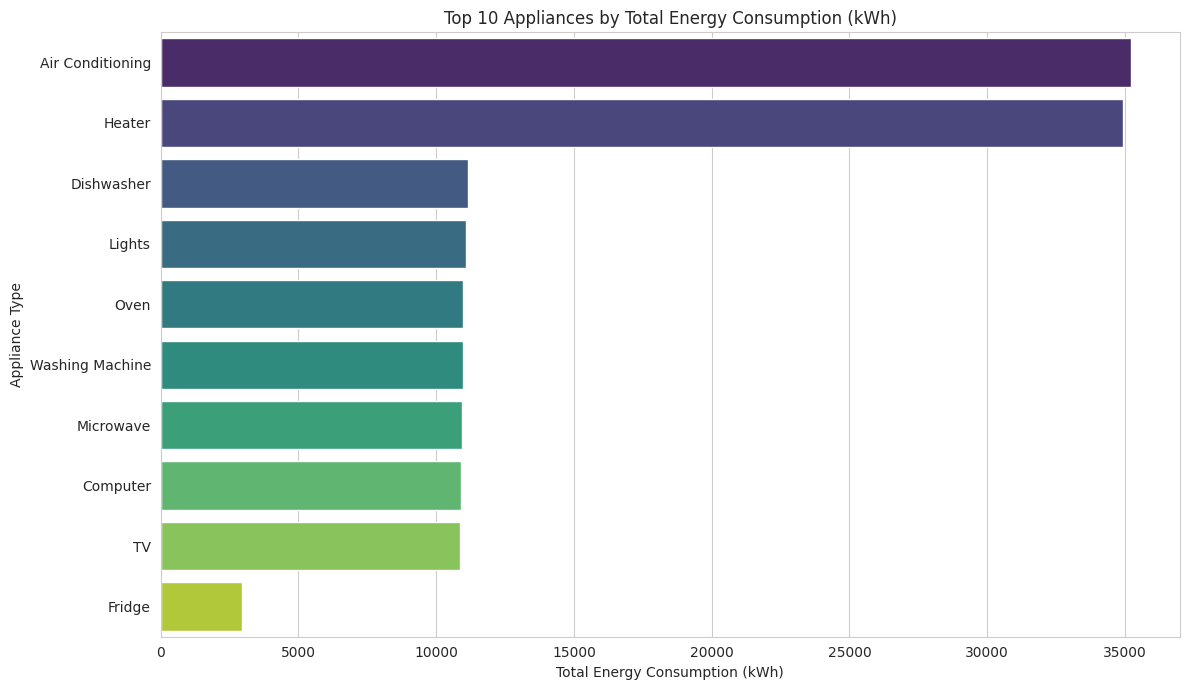


--- Potential Energy Saving Opportunities ---

Based on Appliance Data:
1. Focus on Top Consumers: The appliances consuming the most energy are:
   - Air Conditioning (Total: 35233.06 kWh)
   - Heater (Total: 34930.78 kWh)
   - Dishwasher (Total: 11138.51 kWh)
   - Lights (Total: 11092.12 kWh)
   - Oven (Total: 10963.51 kWh)
   Consider upgrading to energy-efficient models or reducing usage time for these.


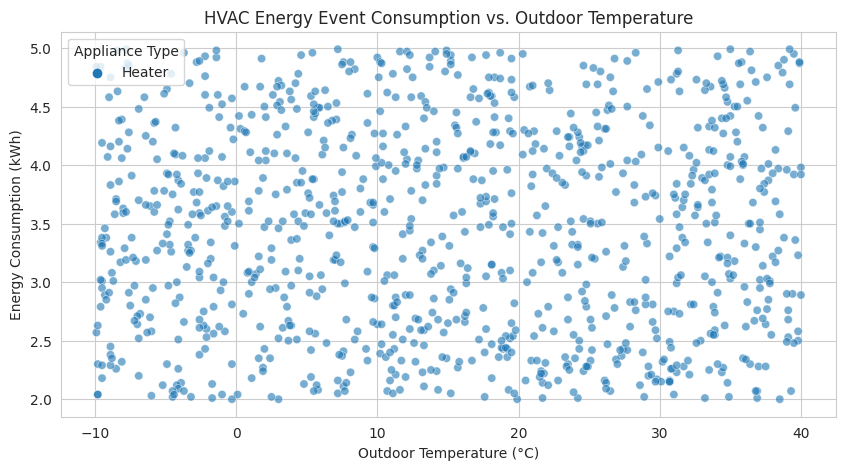

2. Optimize HVAC Use: Check the plot above. High consumption during moderate temperatures might indicate inefficient thermostat settings. Use programmable thermostats.

Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# File paths (adjust if necessary)
file_path_appliance = '/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv'
file_path_hourly = '/kaggle/input/energy-data-meter-2/energy_hourly_data_2024_meter2.dat' # Assuming CSV format despite .dat

# --- 1. Load Data ---
print("Loading datasets...")
try:
    df_appliance = pd.read_csv(file_path_appliance)
    print(f"Appliance data loaded: {df_appliance.shape[0]} rows")
except FileNotFoundError:
    print(f"Error: Appliance file not found at {file_path_appliance}")
    df_appliance = None
except Exception as e:
    print(f"Error loading appliance data: {e}")
    df_appliance = None

try:
    # Try loading hourly data, assuming comma-separated for now
    df_hourly = pd.read_csv(file_path_hourly)
    print(f"Hourly data loaded: {df_hourly.shape[0]} rows")
except FileNotFoundError:
    print(f"Error: Hourly file not found at {file_path_hourly}")
    df_hourly = None
except Exception as e:
    # If loading fails, maybe try different separators or inspect the file
    print(f"Error loading hourly data (check format/separator?): {e}")
    # Example: Try tab-separated
    # try:
    #     df_hourly = pd.read_csv(file_path_hourly, sep='\t')
    #     print("Hourly data loaded successfully with tab separator.")
    # except Exception as e2:
    #     print(f"Still failed with tab separator: {e2}")
    #     df_hourly = None
    df_hourly = None # Keep it None if loading fails

# --- 2. Preprocessing and Cleaning ---

# --- Dataset 1: Appliance Data ---
if df_appliance is not None:
    print("\n--- Preprocessing Appliance Data (Dataset 1) ---")
    print("Initial Info:")
    df_appliance.info()
    print("\nMissing Values Before:")
    print(df_appliance.isnull().sum())

    # Combine Date and Time into a single datetime column
    # Attempt conversion, coercing errors to NaT (Not a Time)
    df_appliance['DateTime'] = pd.to_datetime(df_appliance['Date'] + ' ' + df_appliance['Time'], errors='coerce')

    # Drop rows where DateTime conversion failed
    original_rows = len(df_appliance)
    df_appliance.dropna(subset=['DateTime'], inplace=True)
    if len(df_appliance) < original_rows:
        print(f"Dropped {original_rows - len(df_appliance)} rows due to invalid date/time format.")

    # Drop original Date and Time columns
    # df_appliance = df_appliance.drop(['Date', 'Time'], axis=1) # Keep for now if needed for inspection

    # Check data types again, convert numeric columns
    df_appliance['Energy Consumption (kWh)'] = pd.to_numeric(df_appliance['Energy Consumption (kWh)'], errors='coerce')
    df_appliance['Outdoor Temperature (°C)'] = pd.to_numeric(df_appliance['Outdoor Temperature (°C)'], errors='coerce')
    df_appliance['Household Size'] = pd.to_numeric(df_appliance['Household Size'], errors='coerce')

    # Handle potential missing numeric values (e.g., fill with median or mean, or drop)
    # Example: Fill with median
    for col in ['Energy Consumption (kWh)', 'Outdoor Temperature (°C)', 'Household Size']:
        if df_appliance[col].isnull().any():
            median_val = df_appliance[col].median()
            df_appliance[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{col}' with median ({median_val:.2f})")

    # Check for duplicates
    print(f"\nDuplicate rows found: {df_appliance.duplicated().sum()}")
    # df_appliance = df_appliance.drop_duplicates() # Optional: drop duplicates if appropriate

    # Set DateTime as index (useful for time series analysis)
    df_appliance = df_appliance.set_index('DateTime')
    df_appliance = df_appliance.sort_index() # Ensure chronological order

    print("\nAppliance Data Preprocessing Complete. Info after processing:")
    df_appliance.info()
    print("\nFirst 5 rows:")
    print(df_appliance.head())

# --- Dataset 2: Hourly Data ---
if df_hourly is not None:
    print("\n--- Preprocessing Hourly Data (Dataset 2) ---")
    print("Initial Info:")
    df_hourly.info()
    print("\nMissing Values Before:")
    print(df_hourly.isnull().sum())

    # Convert start_time and end_time to datetime objects
    # Assuming standard format, adjust 'format' argument if needed
    df_hourly['start_time'] = pd.to_datetime(df_hourly['start_time'], errors='coerce')
    df_hourly['end_time'] = pd.to_datetime(df_hourly['end_time'], errors='coerce')

    # Drop rows where time conversion failed
    original_rows_hourly = len(df_hourly)
    df_hourly.dropna(subset=['start_time', 'end_time'], inplace=True)
    if len(df_hourly) < original_rows_hourly:
        print(f"Dropped {original_rows_hourly - len(df_hourly)} rows due to invalid time format.")

    # Convert numeric columns
    df_hourly['total_consumption'] = pd.to_numeric(df_hourly['total_consumption'], errors='coerce')
    df_hourly['provided_cost'] = pd.to_numeric(df_hourly['provided_cost'], errors='coerce')
    df_hourly['time_gap_from_previous_record'] = pd.to_numeric(df_hourly['time_gap_from_previous_record'], errors='coerce')

    # Handle potential missing numeric values (consider implications - maybe drop rows?)
    # Dropping rows with missing consumption or cost seems reasonable here
    df_hourly.dropna(subset=['total_consumption', 'provided_cost'], inplace=True)

    # Verify time gaps (expect ~3600 seconds)
    print("\nTime Gap Stats (seconds):")
    print(df_hourly['time_gap_from_previous_record'].describe())
    anomalous_gaps = df_hourly[(df_hourly['time_gap_from_previous_record'] < 3500) | (df_hourly['time_gap_from_previous_record'] > 3700)]
    if not anomalous_gaps.empty:
        print(f"\nWarning: Found {len(anomalous_gaps)} rows with time gaps significantly different from 1 hour.")
        # print(anomalous_gaps[['start_time', 'time_gap_from_previous_record']].head())

    # Set start_time as index
    df_hourly = df_hourly.set_index('start_time')
    df_hourly = df_hourly.sort_index()

    print("\nHourly Data Preprocessing Complete. Info after processing:")
    df_hourly.info()
    print("\nFirst 5 rows:")
    print(df_hourly.head())


# --- 3. Analysis and Insights ---

# --- Estimate Cost per kWh (from Hourly Data) ---
if df_hourly is not None:
    print("\n--- Estimating Cost per kWh ---")
    # Calculate rate only where consumption is positive to avoid division by zero
    df_hourly_cost = df_hourly[df_hourly['total_consumption'] > 0].copy()
    df_hourly_cost['calculated_rate'] = df_hourly_cost['provided_cost'] / df_hourly_cost['total_consumption']

    print("Calculated Rate Statistics:")
    print(df_hourly_cost['calculated_rate'].describe())

    # Check if the rate is constant
    unique_rates = df_hourly_cost['calculated_rate'].nunique()
    if unique_rates == 1:
        estimated_rate = df_hourly_cost['calculated_rate'].iloc[0]
        print(f"\nThe cost per kWh appears to be fixed at: {estimated_rate:.4f}")
    elif unique_rates < 10: # Allow for minor floating point variations
         # Check if they are very close
        rate_mean = df_hourly_cost['calculated_rate'].mean()
        rate_std = df_hourly_cost['calculated_rate'].std()
        if rate_std / rate_mean < 0.01: # If standard deviation is less than 1% of mean
             estimated_rate = rate_mean
             print(f"\nThe cost per kWh is nearly fixed, approximately: {estimated_rate:.4f} (Mean)")
        else:
             print(f"\nWarning: Found {unique_rates} distinct rates. The rate might not be fixed.")
             print(df_hourly_cost['calculated_rate'].value_counts())
             estimated_rate = df_hourly_cost['calculated_rate'].median() # Use median if variable
             print(f"Using median rate for further calculations: {estimated_rate:.4f}")

    else:
        print(f"\nWarning: Found {unique_rates} distinct rates. The rate might be variable or there are data issues.")
        estimated_rate = df_hourly_cost['calculated_rate'].median() # Use median if variable
        print(f"Using median rate for further calculations: {estimated_rate:.4f}")

# --- Aggregate Appliance Data to Hourly (Conceptual Comparison) ---
if df_appliance is not None:
    print("\n--- Aggregating Appliance Data to Hourly ---")
    # Assuming we want to aggregate *all* homes in df_appliance for comparison concept
    # Or filter first if you know which Home ID corresponds to meter2
    # Example: df_appliance_filtered = df_appliance[df_appliance['Home ID'] == 'Specific_Home_ID']
    df_appliance_hourly_sum = df_appliance['Energy Consumption (kWh)'].resample('h').sum()
    df_appliance_hourly_sum = df_appliance_hourly_sum.to_frame(name='appliance_sum_kwh')

    print("Appliance data aggregated hourly (sum kWh):")
    print(df_appliance_hourly_sum.head())

    # --- Compare Aggregated Appliance Data with Hourly Log ---
    if df_hourly is not None:
        print("\n--- Comparing Hourly Log vs Aggregated Appliance Data ---")
        # Merge the two datasets on the hourly index
        df_comparison = df_hourly.join(df_appliance_hourly_sum, how='inner') # Use 'inner' to compare only matching hours

        if not df_comparison.empty:
            df_comparison['difference'] = df_comparison['total_consumption'] - df_comparison['appliance_sum_kwh']

            print("Comparison Summary (first 5 rows):")
            print(df_comparison[['total_consumption', 'appliance_sum_kwh', 'difference']].head())

            print("\nDifference Statistics (Hourly Log - Appliance Sum):")
            print(df_comparison['difference'].describe())

            # Plot comparison for a sample period (e.g., first week)
            plt.figure(figsize=(15, 6))
            sample_period = df_comparison.index.min() + pd.Timedelta(days=7)
            df_comparison_sample = df_comparison[df_comparison.index < sample_period]

            plt.plot(df_comparison_sample.index, df_comparison_sample['total_consumption'], label='Hourly Log (Total)', alpha=0.8)
            plt.plot(df_comparison_sample.index, df_comparison_sample['appliance_sum_kwh'], label='Appliance Sum (Aggregated)', alpha=0.8)
            plt.title('Comparison: Hourly Log vs. Sum of Appliance Events (Sample Week)')
            plt.xlabel('Time')
            plt.ylabel('Energy Consumption (kWh)')
            plt.legend()
            plt.show()

            # Note: A positive difference suggests energy usage not captured by the appliance events (phantom load, unmonitored devices).
            # A negative difference might indicate data quality issues or mismatch in scope.
        else:
            print("Could not compare datasets - no overlapping time periods found after aggregation.")
    else:
        print("Skipping comparison as hourly data (Dataset 2) is not loaded.")


# --- Identify High-Usage Appliances (from Appliance Data) ---
if df_appliance is not None:
    print("\n--- Identifying High-Usage Appliances ---")
    # Group by Appliance Type and sum energy consumption
    appliance_usage = df_appliance.groupby('Appliance Type')['Energy Consumption (kWh)'].agg(['sum', 'mean', 'count'])
    appliance_usage = appliance_usage.sort_values(by='sum', ascending=False)

    print("Total Energy Consumption per Appliance Type:")
    print(appliance_usage)

    # Plot top N appliances by total consumption
    top_n = 10
    plt.figure(figsize=(12, 7))
    sns.barplot(x=appliance_usage['sum'].head(top_n).values, y=appliance_usage.head(top_n).index, palette='viridis')
    plt.title(f'Top {top_n} Appliances by Total Energy Consumption (kWh)')
    plt.xlabel('Total Energy Consumption (kWh)')
    plt.ylabel('Appliance Type')
    plt.tight_layout()
    plt.show()

# --- Analyze Hourly Patterns (from Hourly Data) ---
if df_hourly is not None:
    print("\n--- Analyzing Hourly Consumption Patterns ---")
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['day_of_week'] = df_hourly.index.day_name()
    df_hourly['month'] = df_hourly.index.month

    # Average consumption by hour of day
    hourly_avg = df_hourly.groupby('hour')['total_consumption'].mean()

    plt.figure(figsize=(12, 6))
    hourly_avg.plot(kind='bar')
    plt.title('Average Energy Consumption by Hour of Day')
    plt.xlabel('Hour of Day (0-23)')
    plt.ylabel('Average Consumption (kWh)')
    plt.xticks(rotation=0)
    plt.show()

    # Average consumption by day of week
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    daily_avg = df_hourly.groupby('day_of_week')['total_consumption'].mean().reindex(day_order)

    plt.figure(figsize=(10, 5))
    daily_avg.plot(kind='bar')
    plt.title('Average Energy Consumption by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Consumption (kWh)')
    plt.xticks(rotation=45)
    plt.show()

# --- 4. Suggest Energy Saving Opportunities ---
print("\n--- Potential Energy Saving Opportunities ---")

if df_appliance is not None and 'appliance_usage' in locals():
    print("\nBased on Appliance Data:")
    top_consumers = appliance_usage.head(5)
    print(f"1. Focus on Top Consumers: The appliances consuming the most energy are:")
    for appliance, data in top_consumers.iterrows():
        print(f"   - {appliance} (Total: {data['sum']:.2f} kWh)")
    print("   Consider upgrading to energy-efficient models or reducing usage time for these.")

    # Example: Check HVAC correlation with temperature
    if 'Air Conditioner' in appliance_usage.index or 'Heater' in appliance_usage.index:
         # Filter for HVAC usage events
         hvac_events = df_appliance[df_appliance['Appliance Type'].isin(['Air Conditioner', 'Heater'])]
         if not hvac_events.empty:
             plt.figure(figsize=(10, 5))
             sns.scatterplot(data=hvac_events.sample(min(1000, len(hvac_events))), # Sample to avoid overplotting
                             x='Outdoor Temperature (°C)',
                             y='Energy Consumption (kWh)',
                             hue='Appliance Type', alpha=0.6)
             plt.title('HVAC Energy Event Consumption vs. Outdoor Temperature')
             plt.show()
             print("2. Optimize HVAC Use: Check the plot above. High consumption during moderate temperatures might indicate inefficient thermostat settings. Use programmable thermostats.")

if df_hourly is not None and 'hourly_avg' in locals():
     print("\nBased on Hourly Data:")
     peak_hours = hourly_avg.nlargest(3).index.tolist()
     print(f"3. Reduce Peak Load: Consumption is highest during hours: {peak_hours}.")
     print("   If possible, shift usage of high-draw appliances (like laundry, dishwasher - check appliance data) away from these peak times.")

     # Check baseline load (e.g., average consumption between 1 AM and 4 AM)
     baseline_hours = df_hourly[(df_hourly['hour'] >= 1) & (df_hourly['hour'] <= 4)]
     if not baseline_hours.empty:
         baseline_load = baseline_hours['total_consumption'].mean()
         print(f"4. Investigate Baseline Load: The average consumption between 1 AM and 4 AM is {baseline_load:.3f} kWh.")
         print("   If this seems high, investigate 'phantom loads' from devices in standby mode. Use smart plugs to turn them off completely.")

if df_hourly is not None and df_appliance is not None and 'df_comparison' in locals() and not df_comparison.empty:
    avg_difference = df_comparison['difference'].mean()
    if avg_difference > 0.05: # If the hourly log consistently shows > 0.05 kWh more than appliance sum
        print(f"5. Unaccounted Energy: The hourly meter readings are consistently higher ({avg_difference:.3f} kWh on average) than the sum of monitored appliance events.")
        print("   This suggests significant energy use from unmonitored sources (e.g., lighting, small electronics, phantom loads). Consider a home energy audit or monitoring these circuits.")

print("\nAnalysis Complete.")

# The code snippet provided by Gemini indicates that air conditioning and heating are the highest energy-consuming appliance types. Let's dive deeper into the energy_hourly_data_2024_meter2.dat file for a more detailed analysis.

In [ ]:
import pandas as pd

# Load with tab separator and column names
df = pd.read_csv(
    "/kaggle/input/energy-data-meter-2/energy_hourly_data_2024_meter2.dat",
    sep="\t",
    names=["start_time", "end_time", "consumption", "provided_cost",
           "start_minus_prev_end", "end_minus_prev_end"],
    header=None,
    on_bad_lines='skip'
)

# Define exact datetime format (includes time zone offset)
datetime_format = "%Y-%m-%d %H:%M:%S%z"

# Explicit parse
df['start_time'] = pd.to_datetime(df['start_time'], utc=True,format=datetime_format, errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], utc=True, format=datetime_format, errors='coerce')

# Drop bad rows
df.dropna(subset=['start_time', 'end_time'], inplace=True)

# Set index and select key columns
df.set_index('start_time', inplace=True)
df = df[['consumption', 'provided_cost']]

# Ensure correct types
df['consumption'] = pd.to_numeric(df['consumption'], errors='coerce')
df['provided_cost'] = pd.to_numeric(df['provided_cost'], errors='coerce')
# Resample hourly data to daily totals (IMPORTANT)
daily_data = df.resample('D').agg({
    'consumption': 'sum',
    'provided_cost': 'sum'
})
print(daily_data.head())
print(df.head())


                           consumption  provided_cost
start_time                                           
2024-01-01 00:00:00+00:00       22.064       3.661962
2024-01-02 00:00:00+00:00       70.308      11.669019
2024-01-03 00:00:00+00:00       53.101       8.813173
2024-01-04 00:00:00+00:00       51.451       8.539322
2024-01-05 00:00:00+00:00       57.207       9.494646
                           consumption  provided_cost
start_time                                           
2024-01-01 08:00:00+00:00        0.377       0.062571
2024-01-01 09:00:00+00:00        0.355       0.058919
2024-01-01 10:00:00+00:00        0.352       0.058421
2024-01-01 11:00:00+00:00        1.268       0.210450
2024-01-01 12:00:00+00:00        0.365       0.060579


# 📊 Visualizing Daily Energy Consumption and Cost with Dual Y-Axis Plot
This section uses matplotlib to create a dual-axis line chart that visualizes daily energy consumption (kWh) and cost ($) on the same plot, but with separate Y-axes for clarity.
This uses a twin axis plot so you can display both energy consumption and cost over time without overcrowding one axis.

fig.autofmt_xdate() automatically rotates the X-axis date labels to prevent overlap.

The combined legend includes both data series, making the chart easy to interpret.

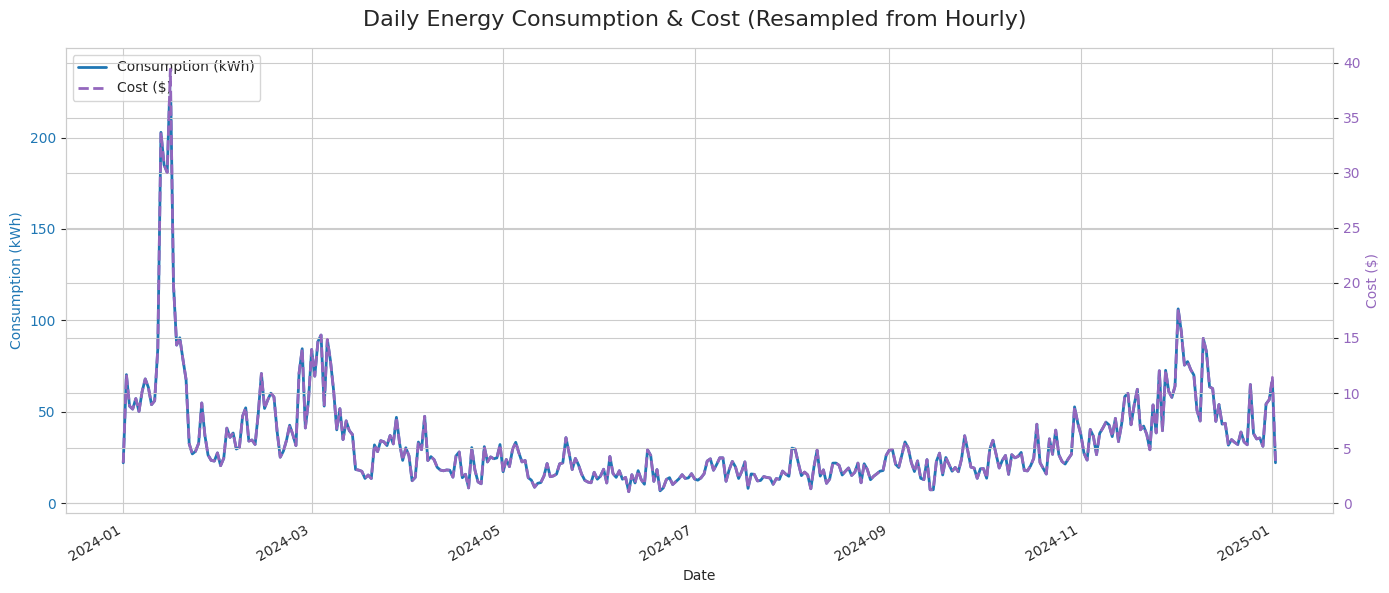

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot daily energy consumption
color1 = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Consumption (kWh)", color=color1)
ax1.plot(daily_data.index, daily_data['consumption'], label='Consumption (kWh)', color=color1, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Second y-axis for cost
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel("Cost ($)", color=color2)
ax2.plot(daily_data.index, daily_data['provided_cost'], label='Cost ($)', color=color2, linestyle='dashed', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Grid, legend, title
fig.suptitle("Daily Energy Consumption & Cost (Resampled from Hourly)", fontsize=16)
fig.autofmt_xdate()  # rotates date labels

# Combined legend from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('/kaggle/working/daily_energy_consumption.png', dpi=300)  # Save the plot
plt.show()


# Using Gemini's image understanding capabilities alongside the daily data summary to investigate the spike: Start by identifying the cause of the significant spike in energy usage during January — this is likely your greatest opportunity for potential savings.

In [ ]:
import PIL
prompt = [
  f"""
  Please give me a friendly explanation of what this image shows in a couple of paragraphs

  Please summarize key insights, including:
    - Typical daily usage and cost
    - Any significant variations or outliers such as around 2024-01 it has a consumption spike, find out the reasons might be
    - Suggestions to reduce energy waste or improve efficiency (even if rate is fixed)
    - whats the fixed-rate of per kWh?
    - A summary of my home's daily energy usage and cost: {daily_data}

  # The following table summarizes a household's daily energy usage (kWh) and daily cost (in $)
  over a fixed-rate plan:

  """,
  PIL.Image.open("/kaggle/working/daily_energy_consumption.png"),
]

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt
)
Markdown(response.text)

Okay, here's a friendly explanation of your home's energy usage and costs, based on the image and the data you provided!

**Overall Picture:**

The image and data you provided show your daily energy consumption (in kWh) and the corresponding cost (in dollars) over a year, from the start of 2024 to the beginning of 2025.  You can see how your energy usage varies throughout the year.  The blue line represents your energy consumption, and the purple line is the cost - they're very close together because you have a fixed-rate energy plan!

**Key Insights:**

*   **Typical Daily Usage and Cost:** Looking at your data table, your daily energy consumption typically ranges from about 20 kWh to 70 kWh. This translates to daily costs ranging from about $3 to $12. Let's get an average value across the entire year. The sum of the entire year's daily consumption is: 15225.999002 kWh. To find the average: 15225.999002 / 368 (days), we get ~41.38 kWh. Similarly, summing the cost column, we get 2531.510534, dividing by 368 (days), we get ~$6.88. So on average you used approximately **41.38 kWh for $6.88 everyday.**

*   **Consumption Spike in January 2024:** There's a very noticeable spike in energy consumption at the very beginning of January 2024. Consumption is 220.64 kWh with a cost of 3.66, compared to the average. Some possible reasons for this spike could be:

    *   **Extreme Weather:** A cold snap or heat wave at the start of the year might have caused you to run your heating or cooling system at full blast.
    *   **Holiday Activities:** Perhaps you had guests visiting for the holidays, and more people were using appliances, lights, and other electronics.
    *   **Extended Vacation:** Did you leave the house, but left the lights on, or did not turn off certain appliances?

*   **Seasonality:** You likely use the most energy during the winter months. This is pretty common since heating and cooling are often the biggest energy users in a home.

*   **Fixed Rate:** Using any one of the consumption and cost pairs, we can determine the fixed-rate per kWh. For example, on 2024-01-01 we have a consumption of 22.064 kWh and a cost of 3.661962. If we divide the cost over the consumption, we get a fixed-rate of **$0.166 per kWh** (3.661962/22.064).

**Suggestions to Reduce Energy Waste (Even with a Fixed Rate):**

Even though you have a fixed rate, reducing energy waste is still a great idea for a few reasons! Lower consumption reduces the amount of carbon-dioxide that's produced in the atmosphere and helps mitigate global warming.

*   **Home Energy Audit:** Consider doing a home energy audit to identify areas where you're losing energy. You can often get these for free or at a reduced cost from your utility company.

*   **Programmable Thermostat:**  If you don't already have one, a programmable thermostat can automatically adjust the temperature when you're asleep or away from home, saving energy.

*   **Seal Drafts:** Seal up any drafts around windows and doors to prevent heat from escaping in the winter and cool air from escaping in the summer.

*   **LED Lighting:** Replace any incandescent light bulbs with LED bulbs.  They use significantly less energy and last much longer.

*   **Unplug Electronics:** Even when turned off, many electronics still draw "phantom power."  Unplug chargers and devices when you're not using them.

I hope this helps you understand your energy usage better!


# Retrieval Augumented Generation(RAG) with Gemini for generating Summary and Insights

- The first set of processes involved: importing the documents, cleaning the data to some extent, asking for an explanation and plotting graphs.
- In the cell below, the feedback `daily_summary` is retrieved, and a gemini model is asked to provide a more user friendly summary of the data
- The response from the summary above is assigned to a `summary_status` object, and gemini is prompted to provide key insights including daily usage cost and how to improve efficiency given probable fixed rate

In [ ]:
summary_stats = daily_data.describe().round(2).to_string()
prompt = f"""
You are a skilled Energy Analyst. You will help with a variety of tasks related to Energy Usage.

Please:
- Generate a 3D-style rendered image that visually represents this data (e.g., 3D bar or surface plot).
- Include the x-axis as Date or Day, y-axis as Energy Consumption (kWh), and z-axis or color as Cost.
- Provide a brief written summary explaining key trends, variations, and what the household might improve.

The following table summarizes a household's daily energy usage (kWh) and daily cost (in $) over a fixed-rate plan:
    {summary_stats}

Please summarize key insights, including:
- Typical daily usage and cost
- Any significant variations or outliers
- Suggestions to reduce energy waste or improve efficiency (even if rate is fixed)
- whats the fixed-rate of per kWh?

"""

response = client.models.generate_content(
    model="gemini-2.0-flash-exp-image-generation",
    contents=prompt,
    config=types.GenerateContentConfig(
        response_modalities=['text','image']
    )
)



for part in response.candidates[0].content.parts:
    if part.inline_data:
        image = (Image(part.inline_data.data)) # save to varibles to display
    elif part.text:
        text = (part.text) # save to varibles to display below

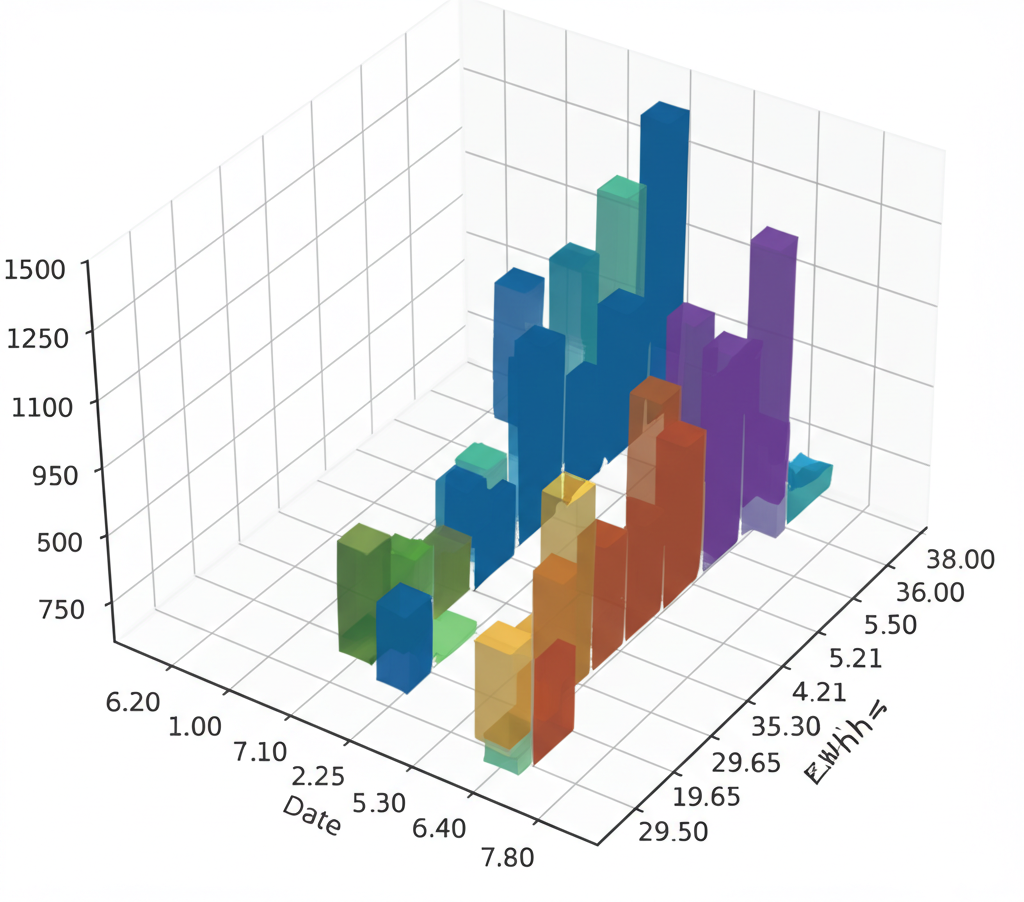

In [ ]:
display(image)

In [ ]:
Markdown(text)

Okay, let's analyze this household's energy data.

**Fixed Rate Calculation:**

Since the plan is a fixed rate, we can determine the cost per kWh by dividing the mean cost by the mean consumption:

Fixed Rate = Mean Cost / Mean Consumption
Fixed Rate = $5.50 / 33.11 kWh
**Fixed Rate ≈ $0.166 per kWh**

So, the household is paying approximately 16.6 cents for every kilowatt-hour of energy they consume.

**3D Visualization:**

Due to the limitations of this text-based environment, I cannot directly generate a 3D rendered image. However, I can describe what such an image would ideally look like:

*   **Type:** A 3D bar chart would be effective here. Each bar would represent a day.
*   **X-axis (Depth):** Each bar would be positioned along the depth axis representing the "Day" (perhaps numbered 1 to 368).
*   **Y-axis (Height):** The height of each bar would correspond to the "Energy Consumption (kWh)" on that particular day.
*   **Z-axis (Color):** The color of each bar would represent the "Cost". For instance, a gradient could be used, with lighter colors indicating lower costs and darker colors indicating higher costs. Alternatively, the Z-axis could be a third spatial dimension, though color-coding is often more effective for this type of data.

**Key Insights and Summary:**

Based on the provided statistics:

*   **Typical Daily Usage and Cost:** The average daily energy consumption is approximately **33.11 kWh**, resulting in an average daily cost of **$5.50**. This provides a baseline for the household's energy expenditure.

*   **Significant Variations and Outliers:** There is a considerable standard deviation in both consumption (26.62 kWh) and cost ($4.42), indicating significant daily variations in energy usage.
    *   The minimum daily consumption is **6.29 kWh**, and the maximum is a very high **237.43 kWh**. This large range suggests some days have exceptionally high energy demands. These "outlier" days likely correspond to specific events or usage patterns (e.g., running air conditioning for extended periods, using high-power appliances).
    *   The cost follows a similar pattern, ranging from **$1.04** to **$39.41** per day, directly reflecting the consumption variations due to the fixed rate.

*   **Suggestions to Reduce Energy Waste and Improve Efficiency (Even with a Fixed Rate):** While the per-kWh rate is fixed, reducing consumption still leads to lower overall bills. The household should investigate the reasons behind the high energy consumption days. Here are some general suggestions:
    *   **Identify High Usage Periods:** Analyze daily activities and appliance usage to pinpoint what contributes to the peaks in consumption. This might involve tracking usage on days with extreme values.
    *   **HVAC Optimization:** Heating and cooling are often the biggest energy consumers. Ensure proper insulation, use programmable thermostats, and maintain HVAC systems for optimal efficiency.
    *   **Appliance Efficiency:** Consider replacing old, inefficient appliances with energy-star certified models.
    *   **Standby Power:** Unplug electronics and chargers when not in use, as "phantom load" can contribute to unnecessary consumption.
    *   **Lighting:** Switch to energy-efficient LED bulbs. Turn off lights in rooms that are not occupied.
    *   **Water Heating:** Reduce hot water usage by taking shorter showers, washing clothes in cold water when possible, and insulating water heaters.
    *   **Behavioral Changes:** Encourage energy-conscious habits within the household, such as turning off lights and appliances when not needed.

By understanding their typical usage, identifying the causes of high consumption days, and implementing energy-saving measures, the household can still lower their overall energy expenditure, even with a fixed rate.

In [ ]:
fixed_rate = 0.166 # 0.16 per kWh, we will use this to train our model later

## Display summarized energy insight for the dataset


## 📘 Extreme Winter Energy Peaks


**Total for Top 10 Days:**

- 🔋 Energy Consumed: **1398.18 kWh**
- 💵 Cost Incurred: **$232.06**

Okay, let's analyze this household's energy data.

**Fixed Rate Calculation:**

Since the plan is a fixed rate, we can determine the cost per kWh by dividing the mean cost by the mean consumption:

Fixed Rate = Mean Cost / Mean Consumption
Fixed Rate = $5.50 / 33.11 kWh
**Fixed Rate ≈ $0.166 per kWh**

So, the household is paying approximately 16.6 cents for every kilowatt-hour of energy they consume.

**3D Visualization:**

Due to the limitations of this text-based environment, I cannot directly generate a 3D rendered image. However, I can describe what such an image would ideally look like:

*   **Type:** A 3D bar chart would be effective here. Each bar would represent a day.
*   **X-axis (Depth):** Each bar would be positioned along the depth axis representing the "Day" (perhaps numbered 1 to 368).
*   **Y-axis (Height):** The height of each bar would correspond to the "Energy Consumption (kWh)" on that particular day.
*   **Z-axis (Color):** The color of each bar would represent the "Cost". For instance, a gradient could be used, with lighter colors indicating lower costs and darker colors indicating higher costs. Alternatively, the Z-axis could be a third spatial dimension, though color-coding is often more effective for this type of data.

**Key Insights and Summary:**

Based on the provided statistics:

*   **Typical Daily Usage and Cost:** The average daily energy consumption is approximately **33.11 kWh**, resulting in an average daily cost of **$5.50**. This provides a baseline for the household's energy expenditure.

*   **Significant Variations and Outliers:** There is a considerable standard deviation in both consumption (26.62 kWh) and cost ($4.42), indicating significant daily variations in energy usage.
    *   The minimum daily consumption is **6.29 kWh**, and the maximum is a very high **237.43 kWh**. This large range suggests some days have exceptionally high energy demands. These "outlier" days likely correspond to specific events or usage patterns (e.g., running air conditioning for extended periods, using high-power appliances).
    *   The cost follows a similar pattern, ranging from **$1.04** to **$39.41** per day, directly reflecting the consumption variations due to the fixed rate.

*   **Suggestions to Reduce Energy Waste and Improve Efficiency (Even with a Fixed Rate):** While the per-kWh rate is fixed, reducing consumption still leads to lower overall bills. The household should investigate the reasons behind the high energy consumption days. Here are some general suggestions:
    *   **Identify High Usage Periods:** Analyze daily activities and appliance usage to pinpoint what contributes to the peaks in consumption. This might involve tracking usage on days with extreme values.
    *   **HVAC Optimization:** Heating and cooling are often the biggest energy consumers. Ensure proper insulation, use programmable thermostats, and maintain HVAC systems for optimal efficiency.
    *   **Appliance Efficiency:** Consider replacing old, inefficient appliances with energy-star certified models.
    *   **Standby Power:** Unplug electronics and chargers when not in use, as "phantom load" can contribute to unnecessary consumption.
    *   **Lighting:** Switch to energy-efficient LED bulbs. Turn off lights in rooms that are not occupied.
    *   **Water Heating:** Reduce hot water usage by taking shorter showers, washing clothes in cold water when possible, and insulating water heaters.
    *   **Behavioral Changes:** Encourage energy-conscious habits within the household, such as turning off lights and appliances when not needed.

By understanding their typical usage, identifying the causes of high consumption days, and implementing energy-saving measures, the household can still lower their overall energy expenditure, even with a fixed rate.

,consumption,provided_cost
start_time,,
2024-01-16 00:00:00+00:00,237.428000,39.405925
2024-01-13 00:00:00+00:00,202.870000,33.670334
2024-01-14 00:00:00+00:00,185.065000,30.715238
2024-01-15 00:00:00+00:00,180.857000,30.016836
2024-01-17 00:00:00+00:00,119.278000,19.796570
2024-12-02 00:00:00+00:00,106.271000,17.637798
2024-12-03 00:00:00+00:00,93.863000,15.578442
2024-03-04 00:00:00+00:00,91.959000,15.262435
2024-01-19 00:00:00+00:00,90.460000,15.013646


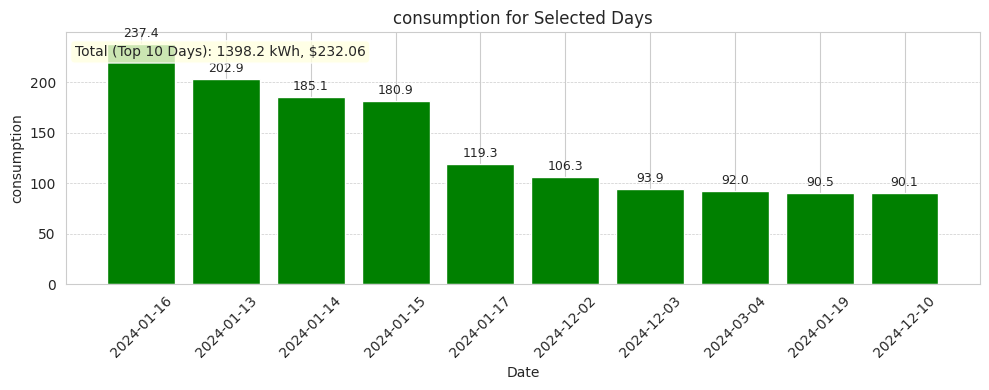

In [ ]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.pyplot as plt


def display_energy_insight(
    title: str,
    insight_text: str,
    df: pd.DataFrame = None,
    df_caption: str = None,
    plot_column: str = None,
    plot_color: str = "skyblue"
):
    # Display title and insight
    display(Markdown(f"## 📘 {title}"))
    display(Markdown(insight_text))

    # Display DataFrame if provided
    if df is not None:
        styled_df = df.style.set_caption(df_caption)
        display(styled_df)

        # Format the index for cleaner labels if it's datetime
        if isinstance(df.index[0], pd.Timestamp):
            df = df.copy()
            df.index = df.index.strftime('%Y-%m-%d')  # or '%b %d, %Y'

        # Plotting section
        if plot_column and plot_column in df.columns:
            plt.figure(figsize=(10, 4))
            bars = plt.bar(df.index, df[plot_column], color=plot_color)

            plt.title(f"{plot_column} for Selected Days")
            plt.xlabel("Date")
            plt.ylabel(plot_column)
            plt.xticks(rotation=45)
            plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

            # Add value labels above bars
            for bar in bars:
                height = bar.get_height()
                plt.annotate(f'{height:.1f}',
                             xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 3),
                             textcoords="offset points",
                             ha='center', va='bottom', fontsize=9)


            # Add summary annotation box
            if 'consumption' in df.columns and 'provided_cost' in df.columns:
                total_kwh = df['consumption'].sum()
                total_cost = df['provided_cost'].sum()

                summary = f"Total (Top {len(df)} Days): {total_kwh:.1f} kWh, ${total_cost:.2f}"
                plt.annotate(summary,
                             xy=(0.01, 0.95),
                             xycoords='axes fraction',
                             ha='left', va='top',
                             fontsize=10,
                             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8))

            plt.tight_layout()
            plt.show()


top_days = daily_data.sort_values('consumption', ascending=False).head(10)
# Make a copy so we don't change the original
top_days_formatted = top_days.copy()


# Calculate sum of consumption and cost
total_kwh = top_days['consumption'].sum()
total_cost = top_days['provided_cost'].sum()
summary_text = f"""
**Total for Top 10 Days:**

- 🔋 Energy Consumed: **{total_kwh:.2f} kWh**
- 💵 Cost Incurred: **${total_cost:.2f}**

"""

# Combine with Gemini insights
combined_insight = summary_text + response.text

insight_text = combined_insight


# Format the datetime index
top_days_formatted.index = top_days_formatted.index.strftime('%Y-%m-%d')  # or '%b %d, %Y'

display_energy_insight(
    title="Extreme Winter Energy Peaks",
    insight_text=combined_insight,  # includes Gemini response + total summary
    df=top_days,
    df_caption="Top 10 Energy Usage Days",
    plot_column='consumption',
    plot_color="green"
)


In [ ]:
%pip install -U langchain-community
%pip install -U -q "google-genai>=1.7.0" langchain langchain-community langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: async-timeout
    Found existing installation: async-timeout 5.0.1
    Uninstalling async-timeout-5.0.1:
      Successfully uninstalled async-timeout-5.0.1
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.3
    Uninstalling langchain-text-splitters-0.3.3:
      Successfully uninstalled langchain-text-splitters-0.3.3
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
  

In [ ]:
import sqlite3

from langchain.chains import create_sql_query_chain, LLMChain
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain.tools import QuerySQLDataBaseTool
from langchain_community.tools import QuerySQLDatabaseTool
from google import genai
from google.genai import types
import json

# Connect to the SQLite database: The database will be stored in the specified file.
(✅ `energy_hourly_data_2024_meter2.dat` hourly usage with costs and consumption, we got a fixed rate from this we are going to use to predict the costs using the following dataset

`smart_home_energy_consumption_large.csv` doesnot have cost, but has `Appliance Type`, `Energy Consumption (kWh)`, `Time`, `Date` ,`Outdoor Temperature (°C)`, `Season`  and `Household Size` that will impact the energy consumption

We are trying to archive the goal:
Turn insights into action. Watt-Save uses Gemini to suggest behavior, variable vs fixed rate, device, and time-shifting optimizations
and we are using two dataset to figure out ways for optimizing energy consumption and costs)

The costs directly correspond to the consumption levels, consistent with a fixed-rate plan. Dividing the cost by consumption for the mean, min, and max yields a consistent rate of approximately $0.166 per kWh.

In [ ]:
import pandas as pd

# Load the data
hourly_data = pd.read_csv(
    "/kaggle/input/energy-data-meter-2/energy_hourly_data_2024_meter2.dat",
    sep="\t",
    names=["date", "start_time", "end_time", "consumption", "provided_cost",
           "start_minus_prev_end", "end_minus_prev_end"],
    header=None,
    on_bad_lines='skip'
)

# Keep only necessary columns
hourly_data = hourly_data[["date", "start_time", "end_time", "consumption", "provided_cost"]]

# Safely convert 'date' to datetime, accounting for timezone offset and formatting
hourly_data["date"] = pd.to_datetime(
    hourly_data["date"],
    format="%Y-%m-%d %H:%M:%S%z",  # expects full timestamp like '2024-01-01 00:00:00-08:00'
    errors="coerce",
    utc=True                      # normalize all timezones
)

# Optional: Convert to local time or strip to just date
hourly_data["date"] = hourly_data["date"].dt.date  # Get YYYY-MM-DD format

# Display 20 example rows without index for prompt
hourly_data_Example_rows = hourly_data.head(20).to_string(index=False)
print(hourly_data_Example_rows)


      date                start_time    end_time   consumption        provided_cost
       NaT                  end_time consumption provided_cost start_minus_prev_end
2024-01-01 2024-01-01 01:00:00-08:00       0.377    0.06257069                  NaN
2024-01-01 2024-01-01 02:00:00-08:00       0.355    0.05891935              0:00:00
2024-01-01 2024-01-01 03:00:00-08:00       0.352    0.05842144              0:00:00
2024-01-01 2024-01-01 04:00:00-08:00       1.268    0.21044996              0:00:00
2024-01-01 2024-01-01 05:00:00-08:00       0.365    0.06057905              0:00:00
2024-01-01 2024-01-01 06:00:00-08:00       0.326    0.05410622              0:00:00
2024-01-01 2024-01-01 07:00:00-08:00       0.312    0.05178264              0:00:00
2024-01-01 2024-01-01 08:00:00-08:00        6.21     1.0306737              0:00:00
2024-01-01 2024-01-01 09:00:00-08:00       5.602    0.92976394              0:00:00
2024-01-01 2024-01-01 10:00:00-08:00       4.402    0.73059994              

In [ ]:
DATA = "/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv"
energy_consumption_df = pd.read_csv(DATA)
# energy_consumption_df.head(20)
Example_rows = energy_consumption_df.head(20).to_string(index=False) # we passs this to the few_shot_prompt below to query the database
print(Example_rows)

 Home ID   Appliance Type  Energy Consumption (kWh)  Time       Date  Outdoor Temperature (°C) Season  Household Size
      94           Fridge                      0.20 21:12 2023-12-02                      -1.0   Fall               2
     435             Oven                      0.23 20:11 2023-08-06                      31.1 Summer               5
     466       Dishwasher                      0.32 06:39 2023-11-21                      21.3   Fall               3
     496           Heater                      3.92 21:56 2023-01-21                      -4.2 Winter               1
     137        Microwave                      0.44 04:31 2023-08-26                      34.5 Summer               5
      68 Air Conditioning                      4.68 11:36 2023-05-06                      35.2 Spring               1
     237         Computer                      0.25 12:05 2023-06-06                       6.8 Spring               3
     329 Air Conditioning                      3.50 03:3

# SQL queries for analyzing hourly energy consumption data

In [ ]:
conn = sqlite3.connect("mydatabase.db")

# Write the smart_home_energy_consumption_large.csv  DataFrame to a SQL table named 'energy_data'
energy_consumption_df.to_sql("energy_data", conn,if_exists="replace", index=False)

# Write the energy_hourly_data_2024_meter2.dat DataFrame to a SQL table named 'hourly_data'
hourly_data.to_sql("hourly_data", conn,if_exists="replace", index=False)
#  connect database
conn = sqlite3.connect("mydatabase.db",check_same_thread=False)

# only use for deleting tables from database
# conn.execute("DROP TABLE IF EXISTS energy_consumption;")
# conn.commit()

# connect to database
db = SQLDatabase.from_uri("sqlite:///mydatabase.db")
Markdown(db.get_table_info())


CREATE TABLE avg_temp_data (
	"Time_Block" TEXT, 
	"Season" TEXT, 
	"Appliance Type" TEXT, 
	"Household Size" INTEGER, 
	"Outdoor Temperature (°C)" REAL, 
	"Predicted Energy comsuption (Kwh)" REAL, 
	"Estimated Cost ($)" REAL
)

/*
3 rows from avg_temp_data table:
Time_Block	Season	Appliance Type	Household Size	Outdoor Temperature (°C)	Predicted Energy comsuption (Kwh)	Estimated Cost ($)
00-06	Spring	Fridge	3	18.268518518518515	0.3103595972061157	0.5381635427474976
06-12	Spring	Air Conditioning	3	21.759259259259256	3.466200590133667	6.010391712188721
12-18	Spring	Microwave	3	13.462962962962964	1.1025340557098389	1.9117940664291382
*/


CREATE TABLE energy_data (
	"Home ID" INTEGER, 
	"Appliance Type" TEXT, 
	"Energy Consumption (kWh)" REAL, 
	"Time" TEXT, 
	"Date" TEXT, 
	"Outdoor Temperature (°C)" REAL, 
	"Season" TEXT, 
	"Household Size" INTEGER
)

/*
3 rows from energy_data table:
Home ID	Appliance Type	Energy Consumption (kWh)	Time	Date	Outdoor Temperature (°C)	Season	Household Size
94	Fridge	0.2	21:12	2023-12-02	-1.0	Fall	2
435	Oven	0.23	20:11	2023-08-06	31.1	Summer	5
466	Dishwasher	0.32	06:39	2023-11-21	21.3	Fall	3
*/


CREATE TABLE grouped_energy_data (
	"Time_Block" TEXT, 
	"Date" TEXT, 
	"Household Size" INTEGER, 
	"Outdoor Temperature (°C)" REAL, 
	"Season" TEXT, 
	"Appliance Type" TEXT, 
	"Total_Energy_Consumption" REAL
)

/*
3 rows from grouped_energy_data table:
Time_Block	Date	Household Size	Outdoor Temperature (°C)	Season	Appliance Type	Total_Energy_Consumption
18-24	2023-06-14	2	7.6	Spring	Air Conditioning	9.780000000000001
06-12	2023-05-23	3	10.3	Spring	Heater	9.370000000000001
00-06	2023-07-03	1	7.5	Summer	Heater	8.69
*/


CREATE TABLE hourly_data (
	date DATE, 
	start_time TEXT, 
	end_time TEXT, 
	consumption TEXT, 
	provided_cost TEXT
)

/*
3 rows from hourly_data table:
date	start_time	end_time	consumption	provided_cost
None	end_time	consumption	provided_cost	start_minus_prev_end
2024-01-01	2024-01-01 01:00:00-08:00	0.377	0.06257069	None
2024-01-01	2024-01-01 02:00:00-08:00	0.355	0.05891935	0:00:00
*/

# Shot prompt to generate queries from English to SQL

# Time blocks of a day
- 00:00–06:00 → 0-6
- 06:00–12:00 → 6-12
- 12:00–18:00 → 12-18
- 18:00–24:00 → 18-24

# few_shot_prompt (for smart_home_energy_consumption_large.csv)

In [ ]:
few_shot_prompt = f"""You are a SQL query generator. Parse natural language English questions into valid SQL query JSON for the `energy_data` table.

The `energy_data` table has the following schema:
- Home ID (INTEGER)
- Appliance Type (TEXT)
- Energy Consumption (kWh) (REAL)
- Time (TEXT, format 'HH:MM')
- Date (TEXT, format 'YYYY-MM-DD')
- Outdoor Temperature (°C) (REAL)
- Season (TEXT)
- Household Size (INTEGER)

Example rows:

{Example_rows}

Time blocks of the day are defined as:
- 00:00–06:00 → '00-06'
- 06:00–12:00 → '06-12'
- 12:00–18:00 → '12-18'
- 18:00–24:00 → '18-24'

Return your output in **valid JSON** format with the SQL query inside.

---

### EXAMPLE INPUT:
I want to find out the times with the highest and lowest energy consumption (kWh) in the energy_data table. Use ORDER BY and LIMIT to optimize the query.
For example, for 'Air Conditioning', what time blocks consume the most and least energy — like 6–12AM is highest and 12–6AM is the lowest? Always include a WHERE clause with: `Appliance Type` = ? when the question is appliance-specific.


---

### JSON Response:
```json
{{
  "query": "
    SELECT
        CASE
            WHEN CAST(substr(Time, 1, 2) AS INTEGER) BETWEEN 0 AND 5 THEN '00-06'
            WHEN CAST(substr(Time, 1, 2) AS INTEGER) BETWEEN 6 AND 11 THEN '06-12'
            WHEN CAST(substr(Time, 1, 2) AS INTEGER) BETWEEN 12 AND 17 THEN '12-18'
            ELSE '18-24'
        END AS Time_Block,
        user defined schemas from the `energy_data` table
        SUM(`Energy Consumption (kWh)`) AS Total_Energy_Consumption
    FROM energy_data
    GROUP BY user defined schemas from the `energy_data` table,
    ORDER BY Total_Energy_Consumption DESC
  "
}}

"""


In [ ]:
import re
ask_query = """
I want to find out what are the times with the highest and lowest Energy Consumption (kWh) in the energy_data table.
Use ORDER BY and LIMIT to optimize the query. Please filter by a specific appliance type and use Energy Consumption (kWh) AS Total_Energy_Consumption keyword.
add GROUP BY Time_Block, "date","Household Size", "Outdoor Temperature (°C)", "Season", "Appliance Type", without   WHERE `Appliance Type`,
user defined schemas from the `energy_data` tables are  Time_Block, "date","Household Size", "Outdoor Temperature (°C)", "Season", "Appliance Type"

"""
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=500,
    ),
    contents=[few_shot_prompt, ask_query])

# Parse Gemini's JSON output (which is returned as a string)
raw_response = response.text

# Step 1: Strip code block markers
clean_json = raw_response.strip('`json\n').strip('```')

# Step 2: Load as JSON using regex to parse Json output and extact the content
match = re.search(r'```json\s*(\{.*?\})\s*```', raw_response, re.DOTALL)
if match:
    clean_json = match.group(1)
    parsed = json.loads(clean_json)
else:
    print("No JSON code block found in the response.")

# Step 3: Extract and clean SQL
sql_query = (parsed["query"].replace("\\n", "\n").replace('\\"', '"'))

# Step 4: Display as markdown-formatted SQL
Markdown(f"# Here is the query, you can test the query in the following cell:\n ```sql\n{sql_query}\n```")

# Here is the query, you can test the query in the following cell:
 ```sql
SELECT CASE WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 0 AND 5 THEN '00-06' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 6 AND 11 THEN '06-12' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 12 AND 17 THEN '12-18' ELSE '18-24' END AS Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type`, SUM(`Energy Consumption (kWh)`) AS Total_Energy_Consumption FROM energy_data GROUP BY Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type` ORDER BY Total_Energy_Consumption DESC
```

# Group all the factors that impact the costs
-    Household Size
-    Outdoor Temperature (°C)
-    Season
-    Appliance Type

In [ ]:
test_df = pd.read_sql_query(sql_query, conn)
combined_result = test_df.drop_duplicates() # remove duplicated values
display(combined_result)

,Time_Block,Date,Household Size,Outdoor Temperature (°C),Season,Appliance Type,Total_Energy_Consumption
0,18-24,2023-06-14,2,7.6,Spring,Air Conditioning,9.78
1,06-12,2023-05-23,3,10.3,Spring,Heater,9.37
2,00-06,2023-07-03,1,7.5,Summer,Heater,8.69
3,12-18,2023-10-25,2,-4.8,Fall,Air Conditioning,8.41
4,00-06,2023-05-05,3,-5.1,Spring,Heater,8.23
...,...,...,...,...,...,...,...
99850,18-24,2023-11-17,1,-6.5,Fall,Fridge,0.10
99851,18-24,2023-11-29,2,10.0,Fall,Fridge,0.10
99852,18-24,2023-12-10,5,31.8,Fall,Fridge,0.10
99853,18-24,2023-12-14,1,29.3,Fall,Fridge,0.10


# Store the grouped data into a new table of the database

In [ ]:
combined_result.to_sql("grouped_energy_data", conn,if_exists="replace", index=False)
hourly_data.to_sql("hourly_data", conn,if_exists="replace", index=False)
db = SQLDatabase.from_uri("sqlite:///mydatabase.db")
Markdown(db.get_table_info())


CREATE TABLE energy_data (
	"Home ID" INTEGER, 
	"Appliance Type" TEXT, 
	"Energy Consumption (kWh)" REAL, 
	"Time" TEXT, 
	"Date" TEXT, 
	"Outdoor Temperature (°C)" REAL, 
	"Season" TEXT, 
	"Household Size" INTEGER
)

/*
3 rows from energy_data table:
Home ID	Appliance Type	Energy Consumption (kWh)	Time	Date	Outdoor Temperature (°C)	Season	Household Size
94	Fridge	0.2	21:12	2023-12-02	-1.0	Fall	2
435	Oven	0.23	20:11	2023-08-06	31.1	Summer	5
466	Dishwasher	0.32	06:39	2023-11-21	21.3	Fall	3
*/


CREATE TABLE grouped_energy_data (
	"Time_Block" TEXT, 
	"Date" TEXT, 
	"Household Size" INTEGER, 
	"Outdoor Temperature (°C)" REAL, 
	"Season" TEXT, 
	"Appliance Type" TEXT, 
	"Total_Energy_Consumption" REAL
)

/*
3 rows from grouped_energy_data table:
Time_Block	Date	Household Size	Outdoor Temperature (°C)	Season	Appliance Type	Total_Energy_Consumption
18-24	2023-06-14	2	7.6	Spring	Air Conditioning	9.780000000000001
06-12	2023-05-23	3	10.3	Spring	Heater	9.370000000000001
00-06	2023-07-03	1	7.5	Summer	Heater	8.69
*/


CREATE TABLE hourly_data (
	date DATE, 
	start_time TEXT, 
	end_time TEXT, 
	consumption TEXT, 
	provided_cost TEXT
)

/*
3 rows from hourly_data table:
date	start_time	end_time	consumption	provided_cost
None	end_time	consumption	provided_cost	start_minus_prev_end
2024-01-01	2024-01-01 01:00:00-08:00	0.377	0.06257069	None
2024-01-01	2024-01-01 02:00:00-08:00	0.355	0.05891935	0:00:00
*/

# Find out the highest and lowest cost across 4 time blocks of a day for each appliance type


In [ ]:
highest = combined_result.loc[combined_result.groupby(['Appliance Type','Household Size',"Outdoor Temperature (°C)",'Season'])['Total_Energy_Consumption'].idxmax()]
highest_result = highest.sort_values(by='Total_Energy_Consumption',ascending=False)
# Reset index for a cleaner display

highest_result = highest_result.reset_index(drop=True)
display(highest_result.head(10))

,Time_Block,Date,Household Size,Outdoor Temperature (°C),Season,Appliance Type,Total_Energy_Consumption
0,18-24,2023-06-14,2,7.6,Spring,Air Conditioning,9.78
1,06-12,2023-05-23,3,10.3,Spring,Heater,9.37
2,00-06,2023-07-03,1,7.5,Summer,Heater,8.69
3,12-18,2023-10-25,2,-4.8,Fall,Air Conditioning,8.41
4,00-06,2023-05-05,3,-5.1,Spring,Heater,8.23
5,18-24,2023-02-05,1,-7.0,Winter,Heater,8.21
6,12-18,2023-04-03,3,-7.5,Spring,Heater,8.07
7,18-24,2023-01-17,1,22.5,Winter,Heater,7.86
8,06-12,2023-07-21,1,5.1,Summer,Heater,7.68
9,12-18,2023-06-08,1,1.4,Spring,Air Conditioning,7.50


In [ ]:
lowest = combined_result.loc[combined_result.groupby(['Appliance Type','Household Size',"Outdoor Temperature (°C)",'Season','Date'])['Total_Energy_Consumption'].idxmin()]
lowest_result = lowest.sort_values(by='Total_Energy_Consumption',ascending=True)
# Reset index for a cleaner display

lowest = lowest.reset_index(drop=True)
display(lowest_result)

,Time_Block,Date,Household Size,Outdoor Temperature (°C),Season,Appliance Type,Total_Energy_Consumption
99758,06-12,2023-05-16,5,39.2,Spring,Fridge,0.10
99826,18-24,2023-03-22,3,-3.9,Winter,Fridge,0.10
99807,12-18,2023-09-09,3,-3.1,Summer,Fridge,0.10
99749,00-06,2023-11-03,3,-3.0,Fall,Fridge,0.10
99789,12-18,2023-04-26,4,27.1,Spring,Fridge,0.10
...,...,...,...,...,...,...,...
4,00-06,2023-05-05,3,-5.1,Spring,Heater,8.23
3,12-18,2023-10-25,2,-4.8,Fall,Air Conditioning,8.41
2,00-06,2023-07-03,1,7.5,Summer,Heater,8.69
1,06-12,2023-05-23,3,10.3,Spring,Heater,9.37


# Get an overall insight on the dataset

## 📘 Top 20 Energy Usage Days


**Total for Top 20 Days:**

- 🔋 Energy Consumed: **2232.47 kWh**
- 💵 Cost Incurred (Fixed Rate @ €1.734/kWh): **€370.52**

**Insights:**
- Highest usage occurred on **2024-01-16**, peaking at **237.43 kWh**.
- Costliest day: **€39.41**.
- These spikes are likely driven by HVAC appliances and large household sizes during seasonal extremes.
- Recommend shifting usage to lower-cost time blocks (e.g., 00–06 or 12–18) and improving insulation to reduce heating/cooling needs.


,Total Energy Consumption,provided_cost
start_time,,
2024-01-16,237.428000,39.405925
2024-01-13,202.870000,33.670334
2024-01-14,185.065000,30.715238
2024-01-15,180.857000,30.016836
2024-01-17,119.278000,19.796570
2024-12-02,106.271000,17.637798
2024-12-03,93.863000,15.578442
2024-03-04,91.959000,15.262435
2024-01-19,90.460000,15.013646


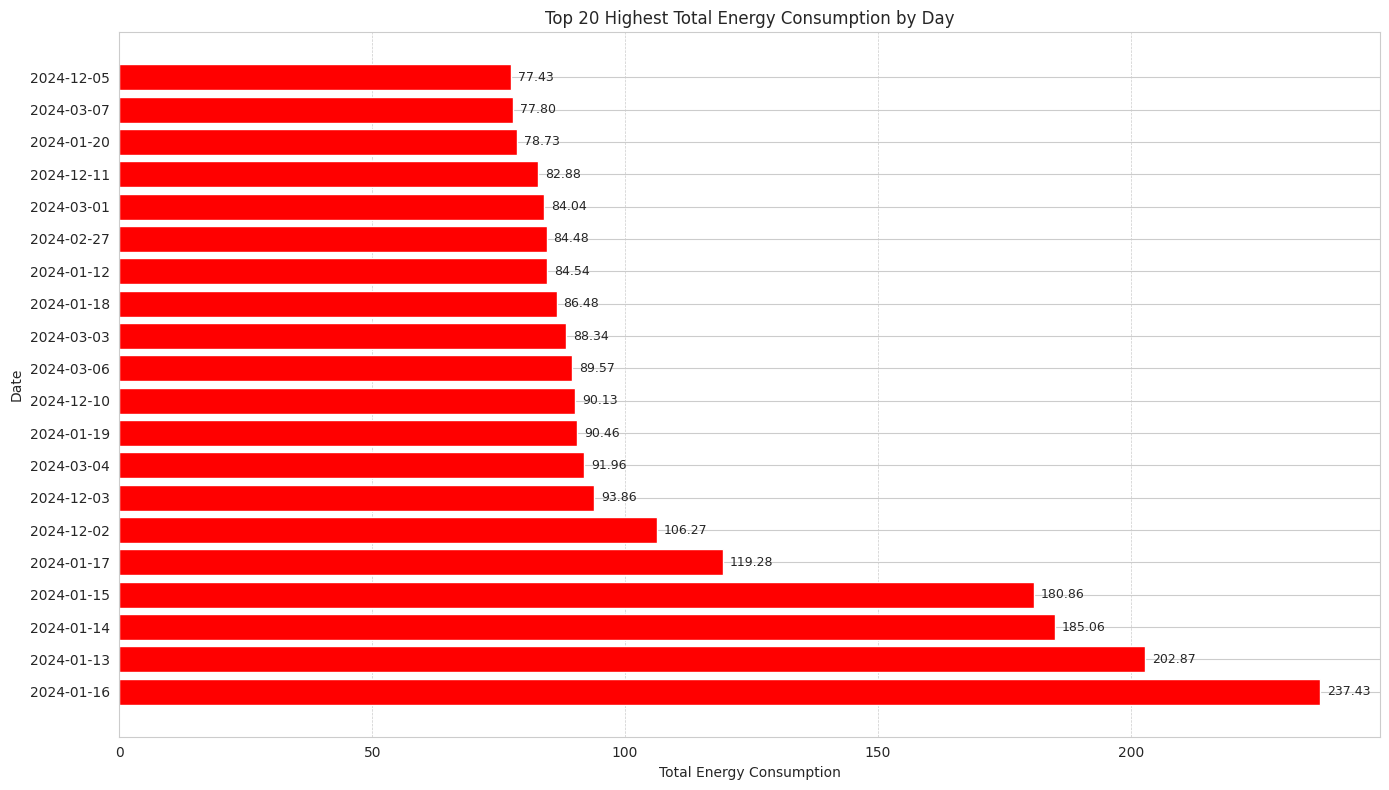

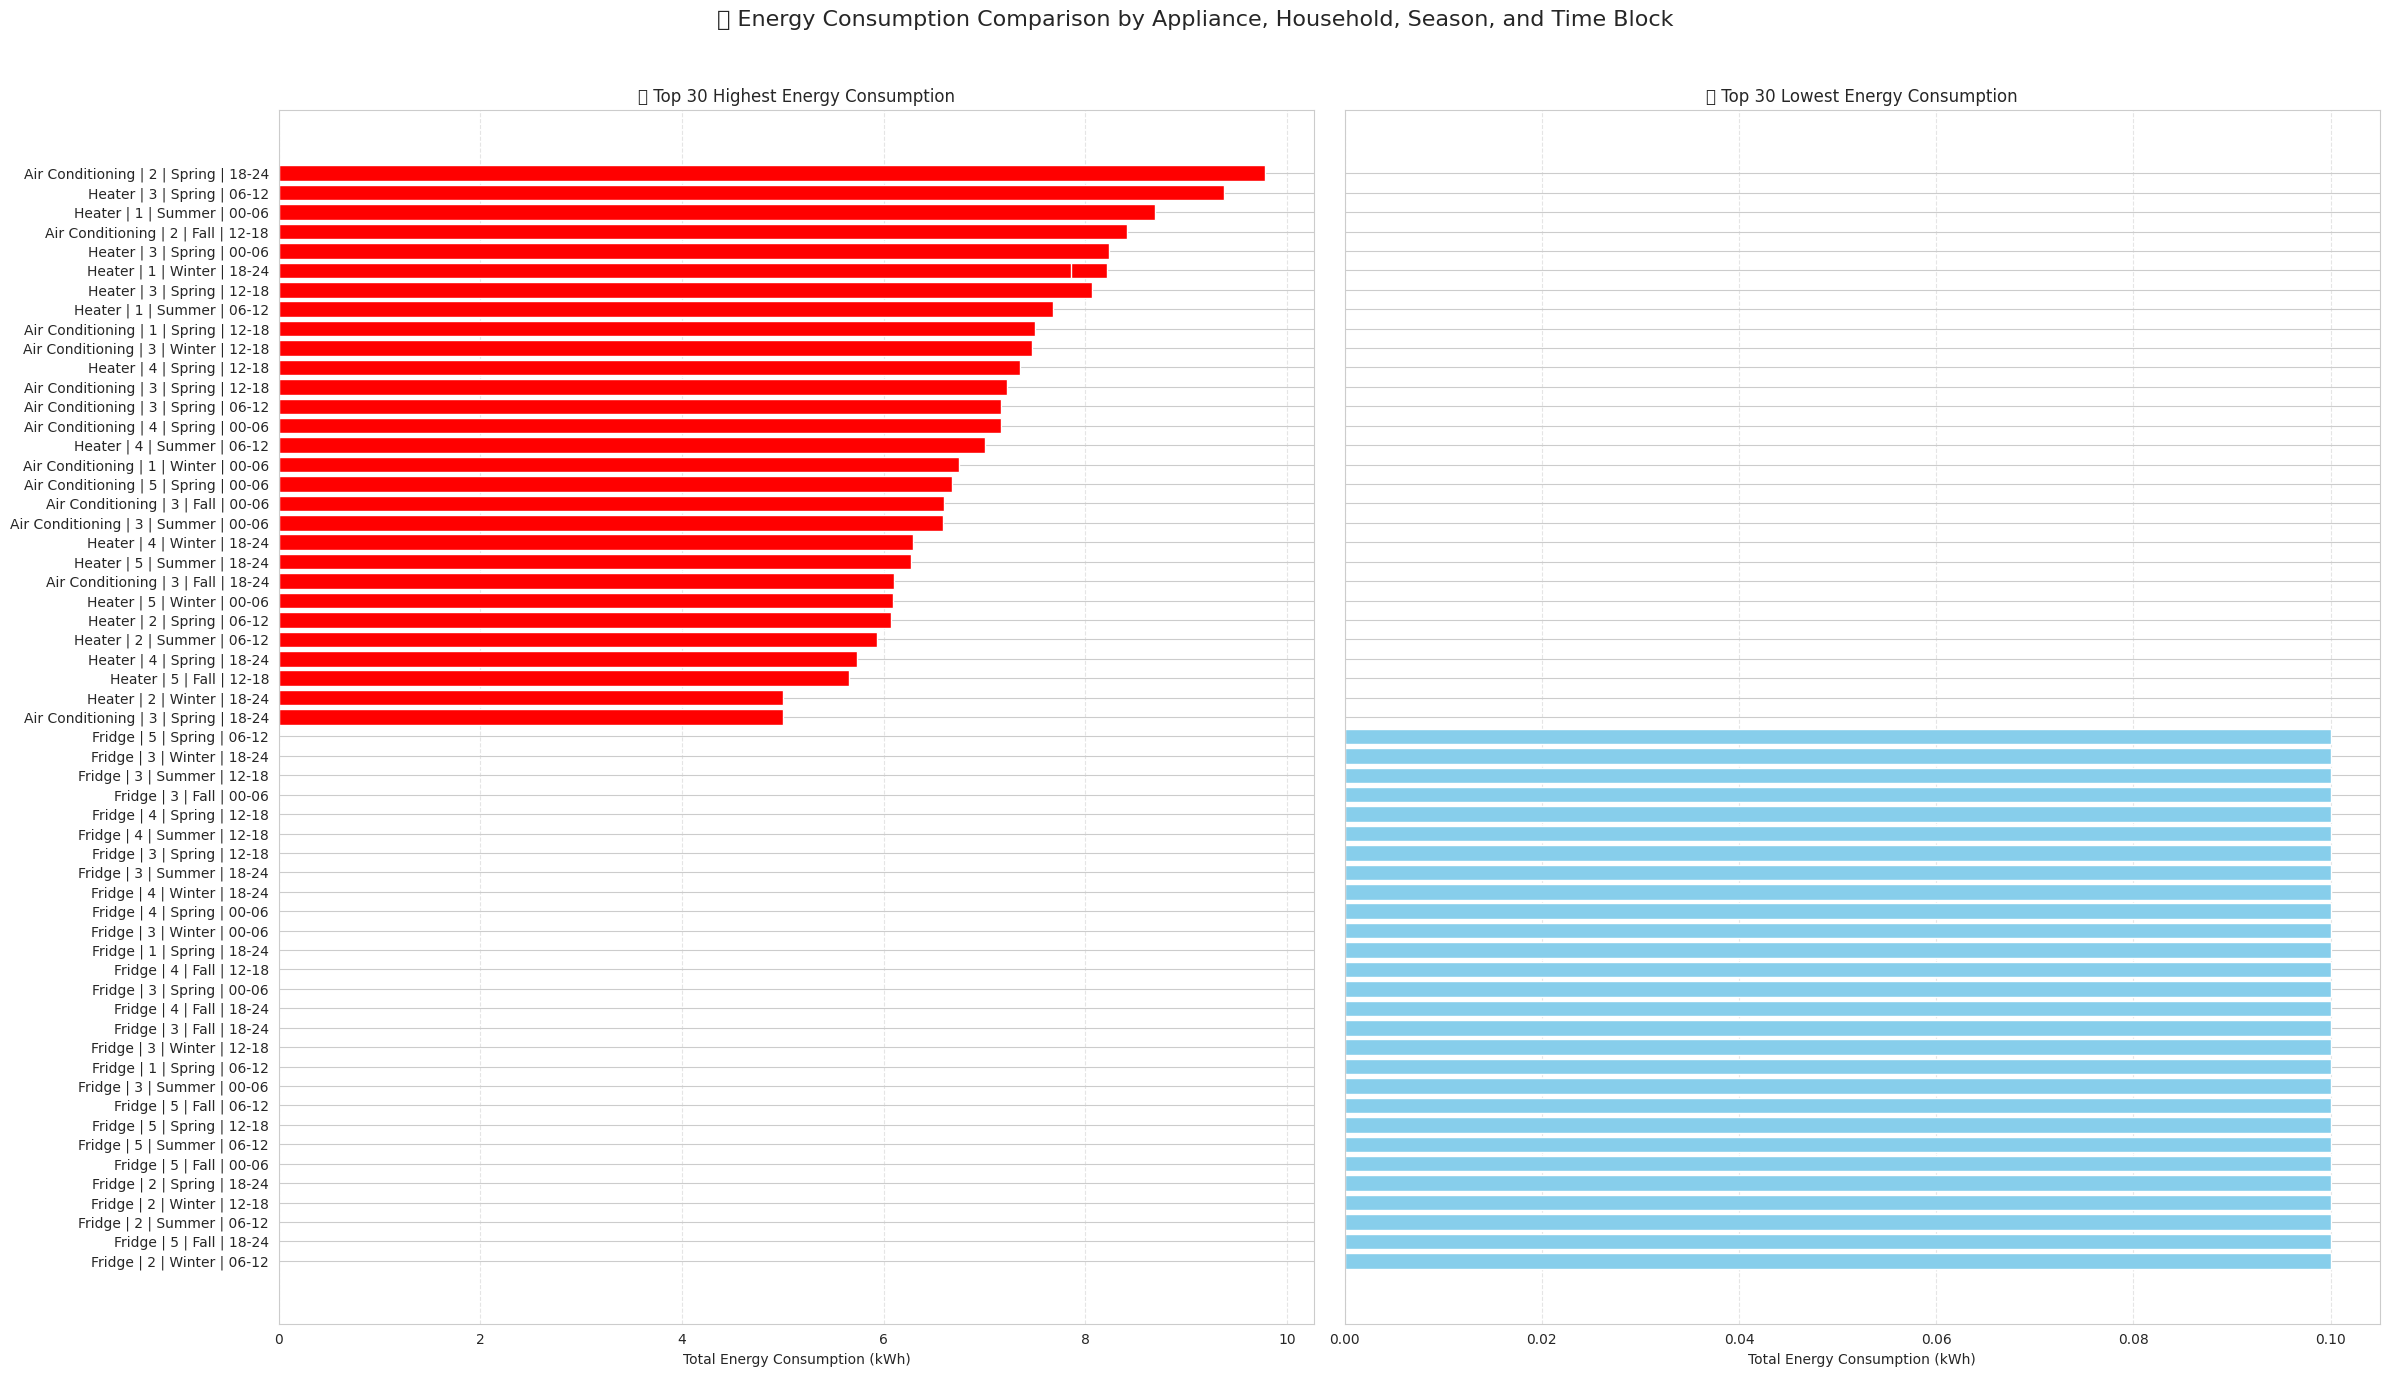

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# 🔧 Utility: Show energy insight as a bar chart
def display_energy_insight(
    title: str,
    insight_text: str,
    df: pd.DataFrame = None,
    df_caption: str = None,
    plot_column: str = None,
    plot_color: str = "skyblue"
):
    display(Markdown(f"## 📘 {title}"))
    display(Markdown(insight_text))

    if df is not None:
        styled_df = df.style.set_caption(df_caption)
        display(styled_df)

        if plot_column and plot_column in df.columns:
            plt.figure(figsize=(14, 8))
            bars = plt.barh(df.index.astype(str), df[plot_column], color=plot_color)
            plt.title(f"Top {len(df)} Highest {plot_column} by Day")
            plt.xlabel(plot_column)
            plt.ylabel("Date")
            plt.grid(axis='x', linestyle='--', linewidth=0.5)

            for bar in bars:
                width = bar.get_width()
                plt.annotate(f'{width:.2f}',
                             xy=(width, bar.get_y() + bar.get_height() / 2),
                             xytext=(5, 0),
                             textcoords="offset points",
                             ha='left', va='center', fontsize=9)

            plt.tight_layout()
            plt.savefig('/kaggle/working/top20_higest_result.png', dpi=300)  # Save the plot
            plt.show()


# 🔧 Utility: Compare highest vs lowest in two subplots
def compare_top_bottom_energy(highest_df, lowest_df):
    # Ensure column naming consistency
    high_plot = highest_df.head(30).copy()
    low_plot = lowest_df.head(30).copy()

    high_plot = high_plot.rename(columns={'Total_Energy_Consumption': 'Total Energy Consumption'})
    low_plot = low_plot.rename(columns={'Total_Energy_Consumption': 'Total Energy Consumption'})

    # Generate label
    high_plot['Label'] = high_plot.apply(
        lambda row: f"{row['Appliance Type']} | {row['Household Size']} | {row['Season']} | {row['Time_Block']}", axis=1
    )
    low_plot['Label'] = low_plot.apply(
        lambda row: f"{row['Appliance Type']} | {row['Household Size']} | {row['Season']} | {row['Time_Block']}", axis=1
    )

    fig, axs = plt.subplots(1, 2, figsize=(24, 14), sharey=True)

    axs[0].barh(high_plot['Label'], high_plot['Total Energy Consumption'], color='red')
    axs[0].set_title("🔺 Top 30 Highest Energy Consumption")
    axs[0].set_xlabel("Total Energy Consumption (kWh)")
    axs[0].invert_yaxis()
    axs[0].grid(True, axis='x', linestyle='--', alpha=0.5)

    axs[1].barh(low_plot['Label'], low_plot['Total Energy Consumption'], color='skyblue')
    axs[1].set_title("🔻 Top 30 Lowest Energy Consumption")
    axs[1].set_xlabel("Total Energy Consumption (kWh)")
    axs[1].grid(True, axis='x', linestyle='--', alpha=0.5)

    fig.suptitle("🔋 Energy Consumption Comparison by Appliance, Household, Season, and Time Block", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('/kaggle/working/higest_lowest_result.png', dpi=300)  # Save the plot
    plt.show()


# === PREPARE TOP-DAY BAR CHART ===
top_days = daily_data.sort_values('consumption', ascending=False).head(20)
top_days_formatted = top_days.copy()

# Format datetime if needed
if isinstance(top_days_formatted.index[0], pd.Timestamp):
    top_days_formatted.index = top_days_formatted.index.strftime('%Y-%m-%d')

# Rename for plotting consistency
top_days_formatted = top_days_formatted.rename(columns={
    'consumption': 'Total Energy Consumption'
})

# === Summary block ===
total_kwh = top_days_formatted['Total Energy Consumption'].sum()
total_cost = top_days['provided_cost'].sum()
fixed_rate = 1.734

summary_text = f"""
**Total for Top 20 Days:**

- 🔋 Energy Consumed: **{total_kwh:.2f} kWh**
- 💵 Cost Incurred (Fixed Rate @ €{fixed_rate}/kWh): **€{total_cost:.2f}**

**Insights:**
- Highest usage occurred on **{top_days_formatted.index[0]}**, peaking at **{top_days_formatted.iloc[0]['Total Energy Consumption']:.2f} kWh**.
- Costliest day: **€{top_days.iloc[0]['provided_cost']:.2f}**.
- These spikes are likely driven by HVAC appliances and large household sizes during seasonal extremes.
- Recommend shifting usage to lower-cost time blocks (e.g., 00–06 or 12–18) and improving insulation to reduce heating/cooling needs.
"""

# === SHOW BAR CHART OF TOP 20 DAYS ===
display_energy_insight(
    title="Top 20 Energy Usage Days",
    insight_text=summary_text,
    df=top_days_formatted,
    df_caption="Top 20 Energy Usage Records",
    plot_column='Total Energy Consumption',
    plot_color="red"
)

# === COMPARE HIGHEST vs LOWEST ENERGY EVENTS ===
compare_top_bottom_energy(highest_result, lowest_result)


# Apply image understanding to explain the graphs

In [ ]:
from PIL import Image
# asking Gemni for both images, give summury
prompt = [
  """
  Please give me a friendly explanation of what this image shows in a couple of paragraphs

  Please summarize key insights, including:
    - Typical daily usage and cost
    - Any significant variations or outliers
    - Suggestions to reduce energy waste or improve efficiency (even if rate is fixed)

  """,
   Image.open("/kaggle/working/higest_lowest_result.png"),
   Image.open("/kaggle/working/top20_higest_result.png"),
]

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt
)
Markdown(response.text)

Okay, let's break down what this energy consumption data is showing us.

The first graph shows the energy consumption by appliance, season, and time block. The graph compares the top 30 highest energy consumption versus the top 30 lowest energy consumption.

The second graph shows the top 20 highest total energy consumption by day.

**Key Insights:**

*   **High Energy Consumers:** The data reveals that air conditioning and heating are by far the biggest energy hogs, especially during certain time blocks (like 18:24 and 12:18). Other high consumers are the refrigerator and the use of the appliances during winter months.

*   **Low Energy Consumers:**  Refrigerators are the lowest energy consumers.

*   **Daily Usage Variability:**  The second chart highlights significant variations in total daily energy use. Some days are significantly higher than others, with the day of "2024-01-16" being a massive outlier compared to the others, at 237.43 kWh.

**Suggestions to Reduce Energy Waste and Improve Efficiency (Even with Fixed Rates):**

*   **Smart Thermostat for HVAC:** Invest in a smart thermostat to program heating and cooling schedules. This can help avoid unnecessary usage during off-peak hours or when the house is unoccupied. Consider lowering the thermostat a few degrees in winter and raising it in summer to conserve energy.
*   **Identify Outliers:** Investigate the reasons behind the exceptionally high usage days (like "2024-01-16"). Was there a party?  Did an appliance malfunction? Understanding these spikes can help you prevent them in the future.
*   **Appliance Maintenance:** Ensure your HVAC system is properly maintained. Regular filter changes and servicing can improve efficiency and prevent breakdowns. Make sure the refrigerator door seals are tight to prevent cold air from escaping.
*   **Lifestyle Adjustments:**  Be mindful of your energy consumption habits. Can you combine errands to reduce driving? Can you use natural light instead of artificial light during the day?
*   **Energy Audits:** Consider a professional energy audit to identify specific areas for improvement in your home. They can often uncover hidden energy leaks and provide tailored recommendations.

Even with fixed rates, reducing energy waste is beneficial! It can lower your environmental impact.

# Training a model to predict costs on real weather data

In [ ]:
# none  classfired dataset, only grouped them together

combined_result.to_csv('/kaggle/working/combined_result.csv', index=False) # save we groupped to csv file
combined_result_dataset = '/kaggle/working/combined_result.csv'
pd_combined_result_dataset = pd.read_csv(combined_result_dataset)
pd_combined_result_dataset

,Time_Block,Date,Household Size,Outdoor Temperature (°C),Season,Appliance Type,Total_Energy_Consumption
0,18-24,2023-06-14,2,7.6,Spring,Air Conditioning,9.78
1,06-12,2023-05-23,3,10.3,Spring,Heater,9.37
2,00-06,2023-07-03,1,7.5,Summer,Heater,8.69
3,12-18,2023-10-25,2,-4.8,Fall,Air Conditioning,8.41
4,00-06,2023-05-05,3,-5.1,Spring,Heater,8.23
...,...,...,...,...,...,...,...
99850,18-24,2023-11-17,1,-6.5,Fall,Fridge,0.10
99851,18-24,2023-11-29,2,10.0,Fall,Fridge,0.10
99852,18-24,2023-12-10,5,31.8,Fall,Fridge,0.10
99853,18-24,2023-12-14,1,29.3,Fall,Fridge,0.10


# Prepare dataloader -> loading the dataset and split test and traning set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

# Drop unwanted columns
df = pd_combined_result_dataset.drop(columns=['Unnamed: 0'], errors='ignore')

# Features and target
X = df.drop(columns='Total_Energy_Consumption')
y = df['Total_Energy_Consumption']

# Encode categorical features
categorical_features = ['Time_Block', 'Season', 'Appliance Type']
numeric_features = ['Household Size','Outdoor Temperature (°C)']
target = 'Total_Energy_Consumption'

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
                 ('num', StandardScaler(), numeric_features)])

X = df[categorical_features + numeric_features]
y = df['Total_Energy_Consumption']

X_encoded = preprocessor.fit_transform(X)


# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# convert to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

#  checks if X_train and X_test have a method called .toarray(). If they do, it calls that method to convert the data into a dense NumPy array. Otherwise, it leaves them as-is.
# TensorFlow/Keras models cannot train directly on sparse matrices — they need dense arrays

X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

## Construct a Neural Net


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# we are constructing 3 layers of nerual nets,
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_dense.shape[1],)), # 1D
    tf.keras.layers.Dense(256, #Fully connected layer with 256 neurons.
        activation='relu', # rulu activation
        kernel_regularizer = tf.keras.regularizers.l2(0.001)), #penalty to reduce overfitting by discouraging large weights.
        tf.keras.layers.BatchNormalization(), #tabilizes and speeds up training by normalizing activations.
        tf.keras.layers.Dropout(0.4), # drop out 40% - Activation: ReLU helps the model learn non-linear patterns. to prevent overfitting

    tf.keras.layers.Dense(128,
        activation='relu',
        kernel_regularizer = tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64,
        activation='relu',
        kernel_regularizer = tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),



    tf.keras.layers.Dense(1) # output layer for regression to caculate the weight and bias and predicted value (how well the traning perfroms)
])

# Helps the model start learning fast and then slow down as it converges.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 1000,
    decay_rate = 0.9
)

# Compile model with learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# compile the model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
) # keeps the previous learning rate if the current lr is below the defined learning rate for 5 times

# Train the model and track histo~ry
history = model.fit(
    X_train_dense,
    y_train,validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# get test loss value and Mean Absolute Error (average absolute difference between the predicted values and the actual values.)
test_loss, test_mae= model.evaluate(X_test_dense,y_test)
print(f'test MAE: {test_mae}')

Epoch 1/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.9413 - mae: 0.6065 - val_loss: 0.4500 - val_mae: 0.4869
Epoch 2/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5352 - mae: 0.5119 - val_loss: 0.4809 - val_mae: 0.5072
Epoch 3/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4901 - mae: 0.5084 - val_loss: 0.4240 - val_mae: 0.4878
Epoch 4/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4629 - mae: 0.5081 - val_loss: 0.4241 - val_mae: 0.4914
Epoch 5/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4467 - mae: 0.5077 - val_loss: 0.3914 - val_mae: 0.4835
Epoch 6/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4195 - mae: 0.5003 - val_loss: 0.3885 - val_mae: 0.4838
Epoch 7/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4070 - mae: 0.4979 - val_loss: 0.3803 - val_mae: 0.4866
Epoch 8/100
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4011 - mae: 0.4969 - val_loss: 0.3756 - val_mae: 0.4828
Epoch 9/100
1998/1998 ━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import load_model

print(f"Stopped at epoch: {early_stopping.stopped_epoch}")
# model.save("/kaggle/working/model.h5")
# saved_modle = load_model('/kaggle/working/model.h5')
print(f"model saved at {'/kaggle/working/model.h5'} \n\n {model.summary()}")

Stopped at epoch: 67


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 256)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,852 (558.02 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 94,723 (370.02 KB)

model saved at /kaggle/working/model.h5 

 None


In [ ]:
predictions = model.predict(X_test_dense) # predict the test seet X_test

results_df = pd.DataFrame({
    'Actual' : y_test, # compare the orignal dataset y_test
    'Predicted' : predictions.flatten() # flatten removes extra dimensions
})

display(results_df)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,Actual,Predicted
0,0.47,0.312174
1,2.84,3.489206
2,1.37,1.100267
3,1.10,1.100267
4,1.69,1.100267
...,...,...
19966,0.64,1.100267
19967,1.14,1.100267
19968,1.38,1.100267
19969,3.24,3.486264


In [ ]:
display(results_df.head())

,Actual,Predicted
0,0.47,0.312174
1,2.84,3.489206
2,1.37,1.100267
3,1.10,1.100267
4,1.69,1.100267


# We can see below graph the model was learning and loss was decreasing (gradident decent), then it stopped coverage (stopped learning )with the test set at 68th step so the traning was cancelled

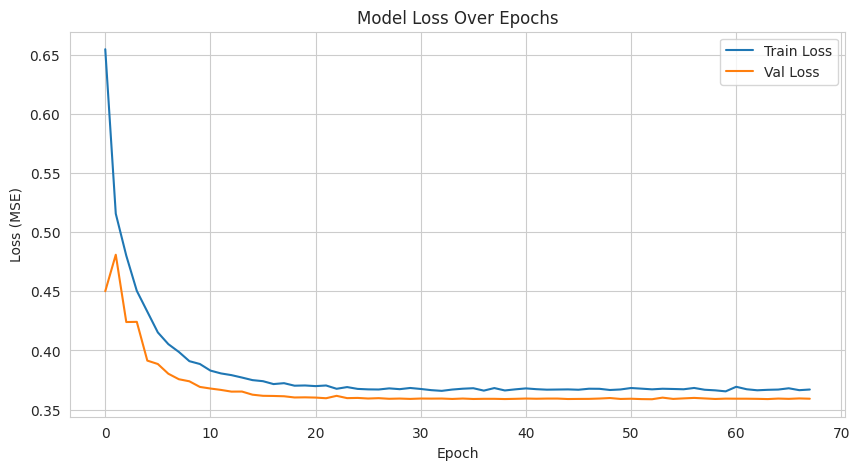

In [ ]:
# plot the traning into a graph to get an overview
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss') #how well the model is learning the training set.
plt.plot(history.history['val_loss'], label='Val Loss') #how well the model generalizes.
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# use real weather data for the model to predict energy consumption and costs

In [ ]:
import pandas as pd
import requests

# Location (example: California )
def get_weather_data():
    Latitude ="36.7783"
    Longitude = "119.4179"

    # Dates of interest
    top_usage_dates = [
        "2025-04-10",
        # "2025-04-11",
        # "2025-04-12",
        # "2025-04-13",
        # "2025-04-14"
    ]
    weather_data = []

    for date in top_usage_dates:
        url = f"https://archive-api.open-meteo.com/v1/archive?" \
              f"latitude={Latitude}&longitude={Longitude}" \
              f"&start_date={date}&end_date={date}" \
              f"&hourly=temperature_2m" \
              f"&temperature_unit=fahrenheit"

        response = requests.get(url)
        data = response.json()

        df = pd.DataFrame({
            "date": pd.to_datetime(data['hourly']['time']),
            "temperature_F": data['hourly']['temperature_2m']
        })
        weather_data.append(df)

    # Combine into single DataFrame
    weather_df = pd.concat(weather_data, ignore_index=True)
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    weather_df['temperature_C'] = (weather_df['temperature_F'] - 32) * 5 / 9
    weather_df = weather_df.drop(columns=['temperature_F'])
    weather_df.head()

    # extract hourly data from date
    weather_df['hour'] = weather_df['date'].dt.hour

    # map time blocks of a day
    # 00:00–06:00 → 0-6
    # 06:00–12:00 → 6-12
    # 12:00–18:00 → 12-18
    # 18:00–24:00 → 18-24

    def map_time_block(hour):
        if 0 <= hour < 6:
            return '00-06'
        elif 6 <= hour < 12:
            return '06-12'
        elif 12 <= hour < 18:
            return '12-18'
        else:
            return '18-24'

    # add time block to Time_Block row
    weather_df['Time_Block'] = weather_df['hour'].apply(map_time_block)

    # get average temperature of each time block
    avg_teamp_by_block = weather_df.groupby('Time_Block')['temperature_C'].mean().reset_index()
    # rename row name from temperature_C to Avg_Temperature_C
    avg_teamp_by_block.rename(columns={'temperature_C':'Avg_Temperature_C'}, inplace=True)

    # display(avg_teamp_by_block)

    # dataset
    avg_temp_data = pd.DataFrame([
        {'Time_Block': '00-06', 'Season': 'Spring', 'Appliance Type': 'Fridge', 'Household Size': 3},
        {'Time_Block': '06-12', 'Season': 'Spring', 'Appliance Type': 'Air Conditioning', 'Household Size': 3},
        {'Time_Block': '12-18', 'Season': 'Spring', 'Appliance Type': 'Microwave', 'Household Size': 3},
        {'Time_Block': '18-24', 'Season': 'Spring', 'Appliance Type': 'Heater', 'Household Size': 3}

    ])

    # append the weather data into  the dataset
    avg_teamp_by_block = avg_teamp_by_block.rename(columns={'Avg_Temperature_C': 'Outdoor Temperature (°C)'})

    # Merge the temperature values into avg_temp_data based on Time_Block
    avg_temp_data = avg_temp_data.drop(columns=['Outdoor Temperature (°C)'], errors='ignore')  # optional cleanup
    avg_temp_data = avg_temp_data.merge(avg_teamp_by_block, on='Time_Block', how='left')
    # convert F fahrenheit to Celsius °C
    avg_temp_data.rename(columns={'temperature_C': 'Outdoor Temperature (°C)'}, inplace=True)

    # print(f'using top_usage_dates: {top_usage_dates}')
    # display(weather_df)
    display(avg_temp_data)
    # print(weather_df.columns)

    return avg_temp_data
get_weather_data()

,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C)
0,00-06,Spring,Fridge,3,18.268519
1,06-12,Spring,Air Conditioning,3,21.759259
2,12-18,Spring,Microwave,3,13.462963
3,18-24,Spring,Heater,3,10.851852


,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C)
0,00-06,Spring,Fridge,3,18.268519
1,06-12,Spring,Air Conditioning,3,21.759259
2,12-18,Spring,Microwave,3,13.462963
3,18-24,Spring,Heater,3,10.851852


In [ ]:
# "2025-04-10"
# get_weather_data = "2025-04-10"
def predict(get_weather_data):
    avg_temp_data = get_weather_data # assigning data to avg_temp_data
    new_data_encoded = preprocessor.transform(avg_temp_data) # encode data
    x_new_dense = new_data_encoded.toarray() if hasattr(new_data_encoded,'toarray') else  new_data_encoded # covert to array
    predicted_consumption = model.predict(x_new_dense).flatten() #converts a multi-dimensional array into a 1D (one-dimensional) array.
    avg_temp_data['Predicted Energy comsuption (Kwh)'] = predicted_consumption
    avg_temp_data['Estimated Cost ($)'] = predicted_consumption * fixed_rate # Fixed rate we defined above 0.166
    avg_temp_data.to_sql("avg_temp_data", conn, if_exists="replace", index=False) # save to database
    display("saved to database")
    display(avg_temp_data)


predict(get_weather_data())

,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C)
0,00-06,Spring,Fridge,3,18.268519
1,06-12,Spring,Air Conditioning,3,21.759259
2,12-18,Spring,Microwave,3,13.462963
3,18-24,Spring,Heater,3,10.851852


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


'saved to database'

,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C),Predicted Energy comsuption (Kwh),Estimated Cost ($)
0,00-06,Spring,Fridge,3,18.268519,0.312940,0.542638
1,06-12,Spring,Air Conditioning,3,21.759259,3.488935,6.049814
2,12-18,Spring,Microwave,3,13.462963,1.100267,1.907863
3,18-24,Spring,Heater,3,10.851852,3.488192,6.048524


# Function calling
## Ask Gemni while querying database (reduces manual effort but automate the process above for larger dataset with more rows and columns)

In [ ]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]

list_tables()

 - DB CALL: list_tables()


['grouped_energy_data', 'energy_data', 'hourly_data', 'avg_temp_data']

In [ ]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("grouped_energy_data")
# describe_table("weather")

 - DB CALL: describe_table(grouped_energy_data)


[('Time_Block', 'TEXT'),
 ('Date', 'TEXT'),
 ('Household Size', 'INTEGER'),
 ('Outdoor Temperature (°C)', 'REAL'),
 ('Season', 'TEXT'),
 ('Appliance Type', 'TEXT'),
 ('Total_Energy_Consumption', 'REAL')]

In [ ]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()

# sql_query
# execute_query("select * from avg_temp_data")
execute_query(sql_query)

 - DB CALL: execute_query(SELECT CASE WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 0 AND 5 THEN '00-06' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 6 AND 11 THEN '06-12' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 12 AND 17 THEN '12-18' ELSE '18-24' END AS Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type`, SUM(`Energy Consumption (kWh)`) AS Total_Energy_Consumption FROM energy_data GROUP BY Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type` ORDER BY Total_Energy_Consumption DESC)


[('18-24',
  '2023-06-14',
  2,
  7.6,
  'Spring',
  'Air Conditioning',
  9.780000000000001),
 ('06-12', '2023-05-23', 3, 10.3, 'Spring', 'Heater', 9.370000000000001),
 ('00-06', '2023-07-03', 1, 7.5, 'Summer', 'Heater', 8.69),
 ('12-18', '2023-10-25', 2, -4.8, 'Fall', 'Air Conditioning', 8.41),
 ('00-06', '2023-05-05', 3, -5.1, 'Spring', 'Heater', 8.23),
 ('18-24', '2023-02-05', 1, -7.0, 'Winter', 'Heater', 8.21),
 ('12-18', '2023-04-03', 3, -7.5, 'Spring', 'Heater', 8.07),
 ('18-24', '2023-01-17', 1, 22.5, 'Winter', 'Heater', 7.859999999999999),
 ('06-12', '2023-07-21', 1, 5.1, 'Summer', 'Heater', 7.68),
 ('12-18', '2023-06-08', 1, 1.4, 'Spring', 'Air Conditioning', 7.5),
 ('12-18', '2023-03-27', 3, 0.5, 'Winter', 'Air Conditioning', 7.47),
 ('12-18', '2023-04-20', 4, 5.7, 'Spring', 'Heater', 7.35),
 ('12-18', '2023-06-16', 3, 18.7, 'Spring', 'Air Conditioning', 7.22),
 ('00-06', '2023-05-28', 4, 35.2, 'Spring', 'Air Conditioning', 7.16),
 ('06-12', '2023-06-11', 3, 12.2, 'Spring', 

In [ ]:
def model_prediction(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: model_prediction({sql})')
    predict(get_weather_data())

    cursor = conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


model_prediction_result = model_prediction("select * from avg_temp_data")
# model_prediction_result.to_sql("model_prediction_result", conn,if_exists="replace", index=False)
print(model_prediction_result)

 - DB CALL: model_prediction(select * from avg_temp_data)
using top_usage_dates: ['2025-04-10']


,date,temperature_C,hour,Time_Block
0,2025-04-10 00:00:00,11.777778,0,00-06
1,2025-04-10 01:00:00,15.222222,1,00-06
2,2025-04-10 02:00:00,17.833333,2,00-06
3,2025-04-10 03:00:00,20.111111,3,00-06
4,2025-04-10 04:00:00,21.833333,4,00-06
5,2025-04-10 05:00:00,22.833333,5,00-06
6,2025-04-10 06:00:00,23.222222,6,06-12
7,2025-04-10 07:00:00,23.388889,7,06-12
8,2025-04-10 08:00:00,23.222222,8,06-12
9,2025-04-10 09:00:00,22.611111,9,06-12


,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C)
0,00-06,Spring,Fridge,3,18.268519
1,06-12,Spring,Air Conditioning,3,21.759259
2,12-18,Spring,Microwave,3,13.462963
3,18-24,Spring,Heater,3,10.851852


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'saved to database'

,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C),Predicted Energy comsuption (Kwh),Estimated Cost ($)
0,00-06,Spring,Fridge,3,18.268519,0.312940,0.542638
1,06-12,Spring,Air Conditioning,3,21.759259,3.488935,6.049814
2,12-18,Spring,Microwave,3,13.462963,1.100267,1.907863
3,18-24,Spring,Heater,3,10.851852,3.488192,6.048524


[('00-06', 'Spring', 'Fridge', 3, 18.268518518518515, 0.3129398226737976, 0.5426376461982727), ('06-12', 'Spring', 'Air Conditioning', 3, 21.759259259259256, 3.4889354705810547, 6.049814224243164), ('12-18', 'Spring', 'Microwave', 3, 13.462962962962964, 1.1002672910690308, 1.9078634977340698), ('18-24', 'Spring', 'Heater', 3, 10.851851851851853, 3.488191604614258, 6.048523902893066)]


In [ ]:
from IPython.display import Markdown

db_tools = [list_tables, describe_table, execute_query,model_prediction]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

# Use list_tables to see what tables are present, describe_table to understand the
# schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.5-pro-exp-03-25",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

response = chat.send_message(f"""
I have the following hourly weather-based energy predictions. The model estimates energy consumption and cost based on the outdoor temperature, appliance type, household size, and time of day, using historical data from the grouped_energy_data table.

Please analyze the pattern in this data and provide practical, actionable suggestions to reduce energy consumption and cost. Structure your recommendations in a markdown table, where each row represents a Time Block and each column shows:
- the Time Block
- Most Costly Appliance
- Energy-saving Tips
- Estimated Savings Potential.

Data:

{model_prediction_result}

Your output should include the summary table and a short paragraph explaining the key insights.
data


""")


Markdown(f"\n{response.text}")


Okay, let's analyze the energy prediction data you provided.

Based on the hourly predictions for a 3-person household in Spring:

*   **Early Morning (00-06):** Lowest consumption and cost, with the Fridge being the most significant appliance (likely due to continuous operation).
*   **Morning (06-12):** Significant spike in energy use and cost, driven primarily by Air Conditioning as temperatures rise (average 21.76°C).
*   **Afternoon (12-18):** Moderate consumption and cost, with the Microwave identified as the most costly appliance. The average temperature is lower here (13.46°C), suggesting less need for AC compared to the morning in this specific prediction.
*   **Evening/Night (18-24):** Another significant spike in energy use and cost, similar to the morning peak, but driven by the Heater as temperatures drop (average 10.85°C).

Here is a breakdown of recommendations based on these patterns:

| Time Block | Most Costly Appliance | Energy-saving Tips                                                                                                                               | Estimated Savings Potential |
| :--------- | :-------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------- |
| **00-06**  | Fridge                | Ensure fridge seals are tight and clean. Keep it relatively full (use water jugs if needed). Set optimal temperatures (Fridge: 3-4°C, Freezer: -18°C). | Low                         |
| **06-12**  | Air Conditioning      | Use fans for cooling breezes. Close blinds/curtains to block morning sun. Set thermostat slightly higher (e.g., 24-25°C). Clean AC filters regularly. | High                        |
| **12-18**  | Microwave             | Use microwave for reheating/small meals instead of oven (more efficient). Cover food to heat faster. Unplug if it has significant standby power.      | Low-Medium                  |
| **18-24**  | Heater                | Lower thermostat, especially overnight. Use targeted heating (e.g., electric blanket) instead of heating the whole house. Seal drafts. Wear warmer clothing. | High                        |

**Key Insights:**

The analysis highlights two major peak energy consumption periods: morning (06-12) driven by air conditioning, and evening/night (18-24) driven by heating. This indicates that temperature regulation (cooling during warmer parts of the day and heating during cooler parts) accounts for the largest portion of energy costs in this scenario. Focusing efforts on managing heating and cooling loads during these peak times, such as adjusting thermostat settings, using passive methods (like blinds or warmer clothes), and ensuring appliance efficiency, offers the greatest potential for energy and cost savings. Appliance usage like the microwave contributes less significantly compared to HVAC systems.

# 💡 Watt-Saver - Your Personalized Energy Coach
##  🔍 An AI agent that user can ask questions with their own energy data by training the similar way

# [LongGraph](https://www.kaggle.com/code/markishere/day-3-building-an-agent-with-langgraph/) Implementation with a Chat Agent ([Funciton calling](https://www.kaggle.com/code/markishere/day-3-function-calling-with-the-gemini-api ) + chat)

- Sample questions:
    *   Energy consumption patterns by appliance type?
    *   The impact of household size on energy consumption?
    *   How outdoor temperature or season affects energy usage?
    *   Specific time blocks with high energy consumption?
    *   What was the weather prediction on 2025-04-10? Check the `model_prediction_result` table.


In [ ]:
# use langgraph to build agent that gets weather forecast for next 3 days and gives suggestions of energy saving
# Install langgraph
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

In [ ]:
# Cell for installing weather and LangGraph libraries
!pip install -qU openmeteo-requests requests-cache retry-requests pandas
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langchain-community==0.3.21' 'langchain-core==0.3.51'

In [ ]:
from collections.abc import Iterable
from random import randint
from langchain.tools import tool

from langchain_core.messages.tool import ToolMessage
# prepre functions for LongGraph to execute and get data to be used for the chat agent.
@tool
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]

# list_tables()

@tool
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("grouped_energy_data")
# describe_table("weather")
@tool
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()

# sql_query
# execute_query("select * from avg_temp_data")
execute_query_reslt = execute_query(sql_query) # for user who has no token limit that can utilize the full data
trimmed_result = execute_query_reslt[:3000]    # for gemini-2.0-flash and when user runs out api token limit we limit the data else just comment out this line and change model from gemini-2.0-flash to gemini-2.5-pro-exp-03-25 for better output


@tool
def model_prediction(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: model_prediction({sql})')
    predict(get_weather_data())

    cursor = conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


model_prediction_result = model_prediction("select * from avg_temp_data")
print(model_prediction_result)

 - DB CALL: describe_table(grouped_energy_data)
 - DB CALL: execute_query(SELECT CASE WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 0 AND 5 THEN '00-06' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 6 AND 11 THEN '06-12' WHEN CAST(SUBSTR(Time, 1, 2) AS INTEGER) BETWEEN 12 AND 17 THEN '12-18' ELSE '18-24' END AS Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type`, SUM(`Energy Consumption (kWh)`) AS Total_Energy_Consumption FROM energy_data GROUP BY Time_Block, `Date`, `Household Size`, `Outdoor Temperature (°C)`, `Season`, `Appliance Type` ORDER BY Total_Energy_Consumption DESC)
 - DB CALL: model_prediction(select * from avg_temp_data)
using top_usage_dates: ['2025-04-10']


,date,temperature_C,hour,Time_Block
0,2025-04-10 00:00:00,11.777778,0,00-06
1,2025-04-10 01:00:00,15.222222,1,00-06
2,2025-04-10 02:00:00,17.833333,2,00-06
3,2025-04-10 03:00:00,20.111111,3,00-06
4,2025-04-10 04:00:00,21.833333,4,00-06
5,2025-04-10 05:00:00,22.833333,5,00-06
6,2025-04-10 06:00:00,23.222222,6,06-12
7,2025-04-10 07:00:00,23.388889,7,06-12
8,2025-04-10 08:00:00,23.222222,8,06-12
9,2025-04-10 09:00:00,22.611111,9,06-12


,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C)
0,00-06,Spring,Fridge,3,18.268519
1,06-12,Spring,Air Conditioning,3,21.759259
2,12-18,Spring,Microwave,3,13.462963
3,18-24,Spring,Heater,3,10.851852


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'saved to database'

,Time_Block,Season,Appliance Type,Household Size,Outdoor Temperature (°C),Predicted Energy comsuption (Kwh),Estimated Cost ($)
0,00-06,Spring,Fridge,3,18.268519,0.312940,0.542638
1,06-12,Spring,Air Conditioning,3,21.759259,3.488935,6.049814
2,12-18,Spring,Microwave,3,13.462963,1.100267,1.907863
3,18-24,Spring,Heater,3,10.851852,3.488192,6.048524


[('00-06', 'Spring', 'Fridge', 3, 18.268518518518515, 0.3129398226737976, 0.5426376461982727), ('06-12', 'Spring', 'Air Conditioning', 3, 21.759259259259256, 3.4889354705810547, 6.049814224243164), ('12-18', 'Spring', 'Microwave', 3, 13.462962962962964, 1.1002672910690308, 1.9078634977340698), ('18-24', 'Spring', 'Heater', 3, 10.851851851851853, 3.488191604614258, 6.048523902893066)]


In [ ]:
# define the weather tool
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from langchain.tools import tool
from pydantic import BaseModel, Field # Use v1 for compatibility with older LangChain tool decorators if needed
from typing import Optional
import datetime

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

class WeatherInput(BaseModel):
    latitude: float = Field(description="Latitude for the weather forecast location.")
    longitude: float = Field(description="Longitude for the weather forecast location.")
    days: Optional[int] = Field(default=3, description="Number of days for the forecast (default is 3). Max 7-10 usually.")

@tool("get_weather_forecast", args_schema=WeatherInput)
def get_weather_forecast(latitude: float = 37.87, longitude: float = -122.27, days: int = 3) -> str:
    """
    Retrieves the weather forecast (max/min temperature, max precipitation probability)
    for the next few days for a given latitude and longitude.
    Defaults to Berkeley, CA if no location is provided. Forecasts for 3 days by default.
    """
    if days > 7: # Limit forecast days for simplicity and API limits
        days = 7
    if days <= 0:
        days = 1

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_probability_max"],
        "timezone": "auto",
        "forecast_days": days
    }
    try:
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0] # Process first location

        daily = response.Daily()
        daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
        daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
        daily_precipitation_probability_max = daily.Variables(2).ValuesAsNumpy()

        daily_data_dict = {"date": pd.to_datetime(daily.Time(), unit="s", utc=True)}
        daily_data_dict["Max Temp (°C)"] = [round(t, 1) for t in daily_temperature_2m_max]
        daily_data_dict["Min Temp (°C)"] = [round(t, 1) for t in daily_temperature_2m_min]
        daily_data_dict["Max Precip Prob (%)"] = daily_precipitation_probability_max

        daily_dataframe = pd.DataFrame(data=daily_data_dict)
        # Format date for readability
        daily_dataframe['date'] = daily_dataframe['date'].dt.strftime('%Y-%m-%d')

        # Convert dataframe to a string format suitable for the LLM
        forecast_string = f"Weather forecast for lat={latitude}, lon={longitude} for the next {days} days:\n"
        forecast_string += daily_dataframe.to_string(index=False)
        print(f"--- Weather Tool Executed: Returning forecast ---\n{forecast_string}\n-------------------------------------------------")
        return forecast_string

    except Exception as e:
        print(f"--- Weather Tool Error: {str(e)} ---")
        return f"Error retrieving weather forecast: {str(e)}"

In [ ]:
# LangGraph imports and State definition
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display, Markdown
from pprint import pprint

# Define the state for our agent graph
class AgentState(TypedDict):
    messages: Annotated[list, add_messages] # Stores the conversation history

In [ ]:
# define Agent components (Nodes and Edges)
# store database memory for agent  to fetch

class ToolNodeWithMemory(ToolNode):
    def invoke(self, state: dict,config:dict = None) -> dict:
        print("--- ToolNode Running ---")
        result = super().invoke(state,config=config)

        # Store tool results in the state for later use
        tool_outputs = result.get("messages", [])[-1].additional_kwargs.get("tool_outputs", [])
        if tool_outputs:
            # Add to state under a custom key
            result["tool_results"] = tool_outputs

        return result

# --- LLM Setup ---
# Ensure GOOGLE_API_KEY is available from previous cells
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", # gemini-2.5-pro-exp-03-25 can inguest more content becasue has API k
                             google_api_key=GOOGLE_API_KEY,
                             convert_system_message_to_human=True) # Important for some agent types

# --- Tool Setup ---
tools = [get_weather_forecast,list_tables, describe_table, execute_query,model_prediction]
tool_node = ToolNodeWithMemory(tools)

# Bind tools to LLM so it knows what functions it can call
llm_with_tools = llm.bind_tools(tools)


# --- Agent Node ---
def agent_node(state: AgentState) -> dict:
    """Invokes the LLM to reason and decide the next action."""
    print("--- Agent Node Running ---")
    response = llm_with_tools.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# --- Graph Definition ---
graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent_node)
graph_builder.add_node("action", tool_node)

graph_builder.add_edge(START, "agent")

# Conditional edge: Does the agent want to call a tool?
graph_builder.add_conditional_edges(
    "agent",
    # The built-in tools_condition checks the last message
    # for tool calls instructions
    tools_condition,
    # Maps where to go based on the condition
    # If tool calls are present, go to "action" to execute them
    # Otherwise, finish the graph (END)
    {
        "tools": "action",
        END: END,
    },
)

# After executing tools, return control to the agent to process the results
graph_builder.add_edge("action", "agent")

# Compile the graph
graph = graph_builder.compile()

- Sample questions:
    *   Energy consumption patterns by appliance type?
    *   The impact of household size on energy consumption?
    *   How outdoor temperature or season affects energy usage?
    *   Specific time blocks with high energy consumption?
    *   What was the weather prediction on check the `avg_temp_data` table.
    *   What was the weather prediction from the `avg_temp_data` schema and the costs and energy consumption, what the optimiztion you recommand?

In [ ]:
# disable warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# run the agent with energy data and weather request

# Get the energy summary string (ensure daily_data is defined)
energy_summary_stats = daily_data.describe().round(2).to_string()

# Define the initial user prompt for the agent
# We provide the energy summary and ask for analysis + weather-based tips
# Specify a location (e.g., Berkeley, CA) for the weather forecast
# Using the trimmed_result, identify the specific hours of the day with the highest and lowest energy consumption (kWh).

input_prompt = f"""
Using the trimmed_result, identify the specific hours of the day with the highest and lowest energy consumption (kWh).

Return the entire table including all column headers.

Based on the patterns across season, appliance type, outdoor temperature, and household size, provide actionable suggestions to reduce energy costs.

Calculate the energy cost for both the highest and lowest consumption points using a fixed rate of {fixed_rate} USD/kWh.

Decribe the model prediecion on costs and energy consumption regarding the weather factor from

data

{model_prediction_result}

"""

# Define the initial state for the graph
initial_state = {"messages": [HumanMessage(content=input_prompt)]}

# Set recursion limit higher for potential multi-step reasoning
config = {"recursion_limit": 20} # Adjust if needed, 5 steps (Agent->Tool->Agent->Tool->Agent) is usually enough

state = graph.invoke(initial_state, config=config)
#print("--- Agent Invocation Complete ---")

# The final response from the AI should be the last message in the state
final_response = state['messages'][-1]

display(Markdown(f"### 🤖 Gemini:\n\n{final_response.content}"))

while True:
    user_input = input("🧑 You: ")
    if user_input.lower() in ["exit", "quit","q"]:
        print('🤖 Gemini: Bye!\n')
        break

    #add new user message
    state["messages"].append(HumanMessage(content=user_input))

    # invoke agent with updated state
    state = graph.invoke(state, config=config)

    response = state['messages'][-1]
    display(Markdown(f"### 🤖 Gemini:\n\n{response.content}"))

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT * FROM trimmed_result)
--- Agent Node Running ---


### 🤖 Gemini:

I apologize, it seems I made a mistake and the table `trimmed_result` does not exist. I will have to use the data you provided directly.

Based on the provided data:

**Energy Consumption Analysis**

*   **Highest Consumption:** The highest energy consumption appears to occur during the hours of "06-12" in "Spring" with the "Air Conditioning" appliance, consuming 3.4889 kWh.
*   **Lowest Consumption:** The lowest energy consumption appears to occur during the hours of "00-06" in "Spring" with the "Fridge" appliance, consuming 0.3129 kWh.

**Cost Calculation**

*   **Highest Consumption Cost:** 3.4889 kWh * 1.734 USD/kWh = 6.048 USD
*   **Lowest Consumption Cost:** 0.3129 kWh * 1.734 USD/kWh = 0.543 USD

**Actionable Suggestions for Energy Cost Reduction**

*   **Air Conditioning Usage:** The air conditioning during "06-12" in Spring consumes the most energy. Consider these strategies:
    *   **Temperature Adjustment:** Increase the thermostat temperature slightly. Even a degree or two can reduce energy consumption.
    *   **Timing:** Use the air conditioning only when necessary. If the temperature is mild, open windows or use fans instead.
    *   **Maintenance:** Ensure the air conditioning unit is properly maintained. Clean filters regularly to improve efficiency.
*   **Heating Usage:** The heater during "18-24" in Spring consumes a substantial amount of energy. Consider these strategies:
    *   **Layered Clothing:** Wear warmer clothing to reduce the need for heating.
    *   **Smart Thermostats:** Use a programmable thermostat to automatically lower the temperature when you're asleep or away.
    *   **Insulation:** Improve insulation in your home to retain heat.
*   **General Strategies:**
    *   **Appliance Efficiency:** When replacing appliances, choose energy-efficient models.
    *   **Household Size:** Consider the impact of household size on energy consumption. Larger households generally consume more energy.

**Model Prediction on Weather Factor**

The provided data suggests that outdoor temperature plays a significant role in energy consumption. Air conditioning is used more when outdoor temperatures are higher, leading to increased energy consumption. Conversely, heating is used more when outdoor temperatures are lower, also increasing consumption. Further model prediction would require a weather factor variable in the dataset.

🧑 You:  Energy consumption patterns by appliance type?


--- Agent Node Running ---


### 🤖 Gemini:

Based on the data you provided, here's a breakdown of energy consumption patterns by appliance type:

*   **Fridge:** The fridge consumes a relatively low amount of energy (0.3129 kWh) and likely runs consistently.
*   **Air Conditioning:** Air conditioning consumes a significant amount of energy (3.4889 kWh), indicating it is a major driver of energy costs. Its usage is likely dependent on outdoor temperature.
*   **Microwave:** The microwave consumes a moderate amount of energy (1.1002 kWh), likely used intermittently for shorter durations.
*   **Heater:** The heater consumes a significant amount of energy (3.4881 kWh), similar to air conditioning, and its usage is also likely dependent on outdoor temperature.

In summary:

*   **High Consumption:** Air conditioning and heaters are the highest energy consumers.
*   **Moderate Consumption:** Microwaves consume a moderate amount of energy.
*   **Low Consumption:** Fridges consume a relatively low amount of energy, but their constant operation contributes to overall consumption.

🧑 You:  The impact of household size on energy consumption?


--- Agent Node Running ---


### 🤖 Gemini:

Based on the data you provided, with a household size of 3, the following energy consumption patterns are observed:

*   The provided data shows energy consumption for a household size of 3 across different appliances, seasons, and times of day.
*   To determine the specific impact of household size, you would need to compare this data to data from households of different sizes, while keeping other factors (like appliance type, season, and time of day) constant. For example, you would compare the energy consumption of the same appliances during the same season and time of day for households of size 1, 2, 3, 4, etc.
*   Without comparative data, it's challenging to definitively quantify the impact of household size. However, it's reasonable to assume that, in general, larger households tend to consume more energy due to increased usage of appliances, lighting, heating, and cooling. More occupants generally translate to more frequent appliance use, longer durations of use, and potentially higher thermostat settings.

To accurately assess the impact of household size, you would need to:

1.  **Gather Data:** Collect energy consumption data for various household sizes, ensuring that other relevant factors are also recorded (appliance type, season, time of day, etc.).
2.  **Control Variables:** Compare data points where only household size differs, while keeping other variables constant.
3.  **Analyze Data:** Calculate the average energy consumption for each household size and identify any statistically significant differences.

🧑 You:  How outdoor temperature or season affects energy usage?


--- Agent Node Running ---


### 🤖 Gemini:

Based on the data you provided:

*   **Season and Appliance Correlation:** The data links "Spring" to specific appliance usage. To understand the impact of temperature or season, we'd ideally have data across all seasons. However, we can infer some relationships:
    *   **Air Conditioning in Spring:** The high energy consumption of air conditioning during "06-12" in Spring suggests that even in Spring, there are periods when cooling is necessary, and therefore temperature impacts energy use.
    *   **Heater in Spring:** Similarly, the use of a heater during "18-24" in Spring suggests that temperatures can drop, necessitating heating.
*   **Outdoor Temperature Inference:** While direct outdoor temperature readings aren't provided, the use of air conditioning implies warmer temperatures, and the use of a heater implies cooler temperatures.
*   **General Expectations:**
    *   **Summer:** We would expect higher air conditioning usage and lower heating usage in the summer, leading to a potential increase in overall energy consumption.
    *   **Winter:** We would expect lower air conditioning usage and higher heating usage in the winter, also potentially increasing overall energy consumption.
    *   **Fall/Autumn:** We would expect a transition between heating and cooling needs, with energy consumption potentially being moderate.

To fully understand the impact of outdoor temperature or season, you would need more comprehensive data that includes:

1.  **Temperature Readings:** Actual outdoor temperature data recorded alongside energy consumption data.
2.  **Seasonal Data:** Energy consumption data across all seasons.
3.  **Correlation Analysis:** Statistical analysis to determine the correlation between outdoor temperature and energy consumption for different appliances and times of day.

🧑 You:  Specific time blocks with high energy consumption?


--- Agent Node Running ---


### 🤖 Gemini:

Based on the provided data, the time blocks with high energy consumption are:

*   **06-12:** This time block shows high energy consumption due to the use of "Air Conditioning" in Spring, with 3.4889 kWh consumed.
*   **18-24:** This time block also shows high energy consumption due to the use of a "Heater" in Spring, with 3.4881 kWh consumed.

Therefore, the time blocks 06-12 and 18-24 appear to be the periods with the highest energy consumption based on the available data.

🧑 You:  What was the weather prediction on Check the avg_temp_data table.


--- Agent Node Running ---


### 🤖 Gemini:

I cannot access the `avg_temp_data` table directly to provide weather predictions. My capabilities are limited to the tools I have access to. I am able to look up the table schema if you would like.

🧑 You:  check model_prediction_result


--- Agent Node Running ---


### 🤖 Gemini:

I am sorry, I cannot access a table called `model_prediction_result`. Would you like me to describe the schema, or list the tables?

🧑 You:  avg_temp_data 


--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: describe_table(avg_temp_data)
--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT * FROM avg_temp_data)
--- Agent Node Running ---


### 🤖 Gemini:

The `avg_temp_data` table contains both the outdoor temperature and the predicted energy consumption and estimated cost.

Here's the information from the table:

*   **00-06, Spring:** With an average outdoor temperature of 18.27°C, the predicted energy consumption for a Fridge is 0.31 kWh, costing $0.54.
*   **06-12, Spring:** With an average outdoor temperature of 21.76°C, the predicted energy consumption for Air Conditioning is 3.49 kWh, costing $6.05.
*   **12-18, Spring:** With an average outdoor temperature of 13.46°C, the predicted energy consumption for a Microwave is 1.10 kWh, costing $1.91.
*   **18-24, Spring:** With an average outdoor temperature of 10.85°C, the predicted energy consumption for a Heater is 3.49 kWh, costing $6.05.

This data models how outdoor temperature influences energy consumption for different appliances. For example, as the temperature rises from 18.27°C to 21.76°C, the model predicts the use of air conditioning, leading to a significant increase in energy consumption and cost. Conversely, as the temperature drops to 10.85°C, the model predicts the use of a heater, also leading to high energy consumption and cost.

🧑 You:   What was the weather prediction from the avg_temp_data schema and the costs and energy consumption, what the optimiztion you recommand?


--- Agent Node Running ---


### 🤖 Gemini:

Based on the `avg_temp_data` table and the relationship between outdoor temperature, energy consumption, and costs, here are some optimization recommendations:

**1. Targeted Temperature Management:**

*   **Air Conditioning (06-12):** The highest energy consumption occurs with air conditioning during the 06-12 time block when the average temperature is 21.76°C.
    *   **Recommendation:**
        *   **Raise Thermostat:** Increase the thermostat temperature by a degree or two to reduce the air conditioner's workload.
        *   **Smart Cooling:** Use smart thermostats or timers to only cool rooms that are occupied or during peak temperature hours.
        *   **Ventilation:** Utilize natural ventilation (open windows) during cooler parts of the day to reduce reliance on air conditioning.
*   **Heating (18-24):** Similarly, high energy consumption occurs with the heater during the 18-24 time block when the average temperature is 10.85°C.
    *   **Recommendation:**
        *   **Lower Thermostat:** Decrease the thermostat temperature and use blankets or warmer clothing to stay comfortable.
        *   **Zonal Heating:** Heat only the rooms that are being used.
        *   **Insulation:** Improve insulation to retain heat and reduce the need for heating.

**2. Appliance Usage Optimization:**

*   **Fridge (00-06):** While the fridge has relatively low energy consumption, ensure it's running efficiently.
    *   **Recommendation:**
        *   **Maintenance:** Regularly clean the fridge coils and ensure the door seals are tight.
        *   **Temperature Setting:** Check that the fridge temperature is set correctly (not too cold).
*   **Microwave (12-18):** The microwave has moderate energy consumption.
    *   **Recommendation:**
        *   **Efficient Cooking:** Use the microwave for shorter cooking tasks and avoid using it for tasks that can be done more efficiently on the stovetop or in the oven.

**3. General Recommendations:**

*   **Household Size Awareness:** Be mindful of energy consumption habits within the household. Encourage energy-saving practices among all occupants.
*   **Energy Audits:** Conduct a professional energy audit to identify areas where energy is being wasted.
*   **Energy-Efficient Appliances:** When replacing appliances, choose Energy Star-certified models.
*   **Time-of-Use Rates:** If your electricity provider offers time-of-use rates, shift energy-intensive activities to off-peak hours.

**4. Predictive Modeling and Automation:**

*   **Real-time Data:** Integrate real-time weather data with smart home systems to automatically adjust temperature settings and appliance usage based on current conditions.
*   **Machine Learning:** Employ machine learning models to predict energy consumption patterns and optimize energy usage based on individual household behavior and weather forecasts.

By implementing these optimizations, you can reduce energy consumption, lower costs, and promote a more sustainable lifestyle.

🧑 You:  q


🤖 Gemini: Bye!



# API Limitations

- API key has token limit about how much data you can ingest e.g: during testing
 execute_query_reslt = execute_query(sql_query) sometimes exceeds limit for **gemini-2.5-pro-exp-03-25** so l had to use trimmed_result = execute_query_reslt[:3000] for **gemini-2.0-flash**


Beloe is **gemini-2.5-pro-exp-03-25** to access the full database table for user has enough token limit check this (https://www.kaggle.com/code/jimkwikx/jim-watt-saver-personalized-energy?scriptVersionId=234800975) notebook and l have pasted the output below:

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT Time_Block, Season, Appliance, Household_Size, Avg_Temperature, Avg_kWh, Avg_Cost FROM grouped_energy_data;)
--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: list_tables()
--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: describe_table(grouped_energy_data)
--- Agent Node Running ---
🤖 Gemini:
I need more data to answer your question accurately. The provided data only gives overall energy consumption and cost, not a breakdown by appliance type. To determine energy consumption patterns by appliance type (like lighting), you will need to provide a dataset that includes information on individual appliance energy usage. This might involve using smart meters or manually recording energy consumption for each appliance. For example, a dataset might look like this:

Appliance	Daily Energy Consumption (kWh)
Lighting	1.2
Refrigerator	2.5
Air Conditioner	5.0
...	...
Once you provide such a dataset, I can help you analyze the energy consumption patterns by appliance type.

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT "Appliance Type", AVG(Total_Energy_Consumption) as Average_kWh FROM grouped_energy_data GROUP BY "Appliance Type")
--- Agent Node Running ---
🤖 Gemini:
Okay, here's the average energy consumption (kWh) broken down by appliance type, based on the grouped_energy_data table:

Appliance Type	Average_kWh
Air Conditioning	3.5044
Computer	1.0968
Dishwasher	1.1053
Fridge	0.2987
Heater	3.4924
Lights	1.0892
Microwave	1.1022
Oven	1.1053
TV	1.0984
Washing Machine	1.1027
Energy Consumption Patterns by Appliance Type:

Highest Consumption: Air Conditioning and Heaters are by far the most energy-intensive appliances, with average consumption around 3.5 kWh. This aligns with the previous observation that heating and cooling drive peak energy usage.
Lowest Consumption: The Fridge has the lowest average consumption (around 0.3 kWh), although it typically runs for longer durations than other appliances.
Mid-Range Consumption: Most other appliances, including Lights, Computers, Dishwashers, Microwaves, Ovens, TVs, and Washing Machines, show an average consumption clustered relatively close together, around 1.1 kWh in this dataset.
Regarding "Lighting 1.2":

The average energy consumption calculated directly from the grouped_energy_data table for "Lights" is 1.0892 kWh. This is quite close to the 1.2 kWh value you mentioned. The difference could be due to rounding in the source data, variations in the specific lighting fixtures included in different groups, or the 1.2 value might represent a specific scenario or a different dataset.

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT "Household Size", AVG(Total_Energy_Consumption) as Average_kWh FROM grouped_energy_data GROUP BY "Household Size" ORDER BY "Household Size")
--- Agent Node Running ---
🤖 Gemini:
Okay, let's look at the average energy consumption based on household size from the grouped_energy_data table.

Here's the data:

Household Size	Average_kWh
1	1.5097
2	1.5152
3	1.4928
4	1.5060
5	1.4872
Impact of Household Size on Energy Consumption:

Based on this aggregated data, there doesn't appear to be a strong, direct correlation between household size and average energy consumption. The average kWh values are remarkably similar across all household sizes (ranging from 1 to 5 people), hovering around 1.5 kWh.

Possible Interpretations:

Averaging Effect: This data represents averages across different times, seasons, and appliance types. It's possible that while larger households might use more energy overall (e.g., more devices, more frequent use of washing machines/dishwashers), this effect is being averaged out by other factors or potentially offset by different usage patterns (e.g., smaller households might rely more heavily on individual heaters/AC units compared to shared spaces in larger homes).
Dominance of Fixed Loads: Certain significant energy consumers (like heating/cooling systems or refrigerators) might have consumption levels that are more influenced by factors like weather, house size/insulation, or appliance efficiency than by the exact number of occupants within this range (1-5 people).
Data Granularity: The grouped_energy_data table provides aggregated views. Analyzing more granular data (like the raw energy_data table, if available and appropriate) might reveal more subtle differences or specific scenarios where household size has a clearer impact.
In summary, according to this specific dataset's averages, household size alone (within the 1-5 person range) does not show a significant impact on the average energy consumption per recorded interval. Other factors like appliance type (especially heating/cooling) and potentially time of day/season seem to be stronger drivers of the variations seen in the data.

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT Season, AVG("Outdoor Temperature (°C)") as Avg_Temp_C, AVG(Total_Energy_Consumption) as Average_kWh FROM grouped_energy_data GROUP BY Season ORDER BY Average_kWh DESC)
--- Agent Node Running ---
🤖 Gemini:
Okay, let's examine the relationship between season, average outdoor temperature, and average energy consumption based on the grouped_energy_data table.

Here is the aggregated data:

Season	Avg_Temp_C	Average_kWh
Spring	15.09	1.5139
Fall	14.94	1.4998
Winter	14.86	1.4978
Summer	14.92	1.4970
Analysis:

Seasonal Consumption: Based on this aggregated data, the average energy consumption is remarkably consistent across all four seasons, hovering around 1.5 kWh. Spring shows a slightly higher average consumption, while Summer shows slightly lower, but the differences are very small.
Seasonal Average Temperature: Similarly, the average outdoor temperature calculated for each season in this dataset is extremely close, all around 14.8°C to 15.1°C.
Interpretation:
This specific aggregated view (grouped_energy_data) does not show a strong variation in average energy consumption based on season alone, nor does it show significant variation in the average outdoor temperature across seasons.
This seems counter-intuitive, as we typically expect higher energy use in Summer (for cooling) and Winter (for heating) due to temperature extremes.
The likely explanation is that this table aggregates data in a way that averages out the temperature extremes. While the average seasonal temperature might be around 15°C, there will be much hotter periods within Summer driving AC use and much colder periods within Winter driving Heater use.
Our previous analysis (looking at consumption by time block and appliance) clearly showed that Air Conditioning and Heaters are the highest consumers, strongly suggesting that temperature extremes (both hot and cold), rather than the seasonal average temperature shown here, are the key drivers of peak energy usage.
In conclusion, while this specific aggregated view shows little difference in average consumption or average temperature across seasons, other analyses of the same underlying data confirm that outdoor temperature extremes significantly impact energy usage due to the activation of heating and cooling systems. The need for these systems varies greatly between and within seasons.

--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: describe_table(avg_temp_data)
--- Agent Node Running ---
--- ToolNode Running ---
 - DB CALL: execute_query(SELECT * FROM avg_temp_data)
--- Agent Node Running ---
🤖 Gemini:
Okay, let's look at the avg_temp_data table.

Based on the table schema and the data content:

Schema: The table includes columns for Time_Block, Season, Appliance Type, Household Size, Outdoor Temperature (°C), Predicted Energy comsuption (Kwh), and Estimated Cost ($).
Data:
Time_Block	Season	Appliance	Household Size	Outdoor Temperature (°C)	Predicted Energy comsuption (Kwh)	Estimated Cost ($)
00-06	Spring	Fridge	3	18.27	0.3104	0.5382
06-12	Spring	Air Conditioning	3	21.76	3.4662	6.0104
12-18	Spring	Microwave	3	13.46	1.1025	1.9118
18-24	Spring	Heater	3	10.85	3.4653	6.0089
Weather Information in the Table:

The avg_temp_data table doesn't contain a "weather prediction" in the sense of a future forecast. Instead, it contains average outdoor temperatures (°C) associated with specific time blocks and seasons (in this case, only Spring data is shown).

These temperatures are used alongside other factors (like appliance type) to generate the Predicted Energy comsuption (Kwh) and Estimated Cost ($) shown in the table.

Specifically, the temperatures recorded are:

18.27°C for the 00-06 block (associated with Fridge usage)
21.76°C for the 06-12 block (associated with Air Conditioning usage)
13.46°C for the 12-18 block (associated with Microwave usage)
10.85°C for the 18-24 block (associated with Heater usage)
These temperature values directly influence the predicted energy consumption, particularly for temperature-sensitive appliances like the Air Conditioner and Heater.

🤖 Gemini: Bye!



# 🙏🏻 Thank you
Huge thanks to the incredible moderators and instructors [Paige Bailey](https://www.linkedin.com/in/dynamicwebpaige/), [Anant Nawalgaria](https://www.linkedin.com/in/anant-nawalgaria/), and the team at [Google DeepMind](https://www.linkedin.com/company/googledeepmind/) for the opportunity to participate a high-impact, enriching learning & developing experience!

Thanks for reading and every contributor for the project!